Install dependencies if needed

In [1]:
!pip install numpy matplotlib bitstring

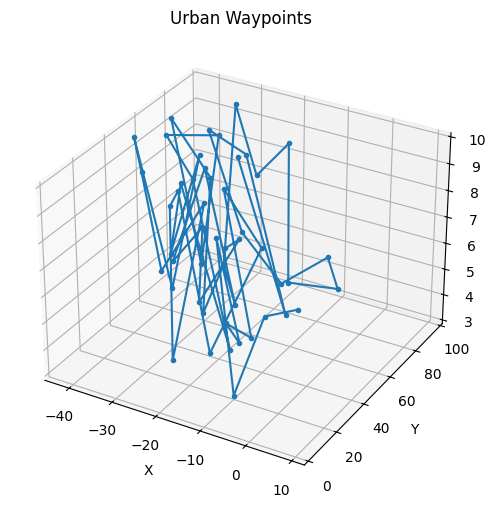

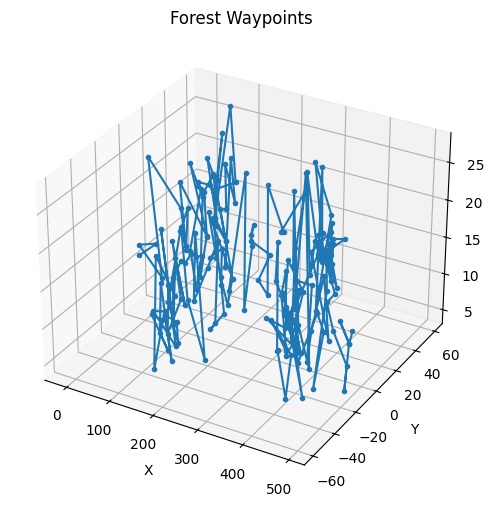

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load waypoints from JSON files
def load_waypoints(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    return np.array(data["waypoints"])

# File paths (Ensure these files are uploaded in Colab)
file_paths = {
    "Urban": "urban_waypoints.json",
    "Forest": "forest_waypoints.json",
    "Mountain": "mountain_waypoints.json",
}

# Load datasets
datasets = {}
for env, path in file_paths.items():
    try:
        datasets[env] = load_waypoints(path)
    except:
        print(f"⚠️ Missing file: {path}. Please upload.")

# Visualize waypoints for each dataset
def visualize_waypoints(waypoints, title):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], marker='o', linestyle='-', markersize=3)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    plt.show()

# Plot all waypoints
for env, data in datasets.items():
    visualize_waypoints(data, f"{env} Waypoints")


# Apply Delta Encoding to GA Waypoints
Now that we’ve visualized the waypoints, let’s apply Delta Encoding as the first compression method.

## Why Delta Encoding?
* Reduces redundancy by storing only the difference between consecutive waypoints instead of absolute positions.
* Useful for sequential data like waypoints since each step is related to the previous one.
* Works well with further compression methods like Huffman and Arithmetic Encoding.

✅ Delta Encoding applied to Urban dataset.
✅ Delta Encoding applied to Forest dataset.
✅ Delta Encoding applied to Mountain dataset.


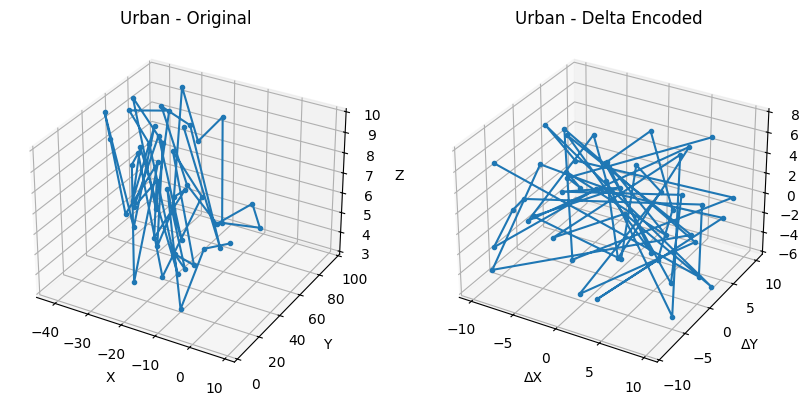

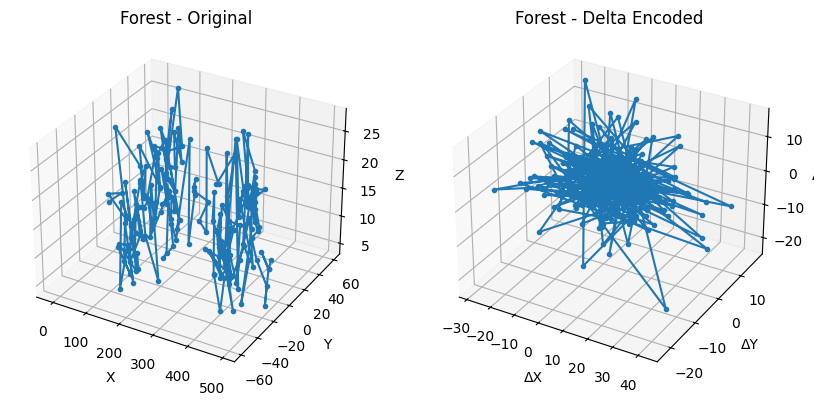

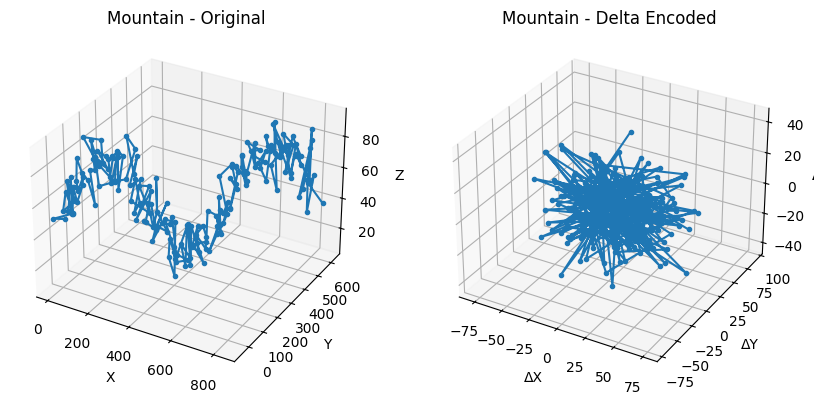

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to apply Delta Encoding to waypoints
def delta_encode_waypoints(waypoints):
    """Converts absolute waypoints into delta differences manually."""
    waypoints_np = np.array(waypoints)
    delta_encoded = np.zeros_like(waypoints_np)
    delta_encoded[0] = waypoints_np[0]  # First waypoint remains the same
    delta_encoded[1:] = waypoints_np[1:] - waypoints_np[:-1]  # Compute differences
    return delta_encoded

# Apply Delta Encoding to all datasets
delta_encoded_datasets = {}
for env, data in datasets.items():
    delta_encoded_datasets[env] = delta_encode_waypoints(data)
    print(f"✅ Delta Encoding applied to {env} dataset.")

# Function to visualize Original vs Delta Encoded Waypoints
def visualize_original_vs_delta(original, delta_encoded, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Delta Encoded Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(delta_encoded[:, 0], delta_encoded[:, 1], delta_encoded[:, 2], marker='o', linestyle='-', markersize=3, label="Delta Encoded")
    ax2.set_xlabel("ΔX")
    ax2.set_ylabel("ΔY")
    ax2.set_zlabel("ΔZ")
    ax2.set_title(f"{title} - Delta Encoded")

    plt.show()

# Plot Original vs Delta Encoded Waypoints for each dataset
for env, data in datasets.items():
    visualize_original_vs_delta(data, delta_encoded_datasets[env], env)


### Compute Compression Metrics for Delta Encoding
Now that we've applied Delta Encoding, let’s calculate:
* Original vs. Encoded Data Size
* Compression Ratio (%)

In [4]:
import sys

# Function to compute data size in bytes
def compute_size(data):
    """Returns the size in bytes of the given NumPy array."""
    return sys.getsizeof(data.tobytes())

# Compute compression metrics
compression_results = []

for env, data in datasets.items():
    original_size = compute_size(data)
    delta_encoded_size = compute_size(delta_encoded_datasets[env])

    compression_ratio = (1 - (delta_encoded_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Delta Encoded Size (bytes)": delta_encoded_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
import pandas as pd
df_results = pd.DataFrame(compression_results)
print(df_results)

# Display formatted table in Colab
from IPython.display import display
display(df_results)


  Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0  


Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0

### The compression ratio is 0%, meaning Delta Encoding did not reduce the data size.

NumPy stores arrays efficiently—the difference between absolute and delta-encoded values may not change memory usage.

Delta Encoding works best when values are highly redundant—GA waypoints have variations, so storing differences may not reduce size significantly.

Since Delta Encoding alone does not provide enough compression, we will now apply Huffman Encoding on top of it.

In [5]:
import heapq
from collections import Counter

# Function to build Huffman tree
def build_huffman_tree(freqs):
    heap = [[weight, [symbol, ""]] for symbol, weight in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return dict(sorted(heap[0][1:], key=lambda p: (len(p[-1]), p)))

# Function to encode data using Huffman
def huffman_encode(data):
    flat_data = data.flatten().astype(int)  # Flatten and convert to int
    freqs = Counter(flat_data)  # Count frequency of values
    huffman_tree = build_huffman_tree(freqs)  # Build Huffman tree
    encoded_data = ''.join(huffman_tree[value] for value in flat_data)  # Encode using tree
    return encoded_data, huffman_tree

# Apply Huffman Encoding to Delta Encoded Data
huffman_encoded_datasets = {}
for env, data in delta_encoded_datasets.items():
    huffman_encoded_datasets[env], _ = huffman_encode(data)
    print(f"✅ Huffman Encoding applied to {env} dataset.")

# Compute new size and compression ratio
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    delta_encoded_size = compute_size(delta_encoded_datasets[env])
    huffman_size = len(huffman_encoded_datasets[env]) // 8  # Convert bits to bytes

    compression_ratio_huffman = (1 - (huffman_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Delta Encoded Size (bytes)": delta_encoded_size,
        "Huffman Encoded Size (bytes)": huffman_size,
        "Compression Ratio (%)": round(compression_ratio_huffman, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


✅ Huffman Encoding applied to Urban dataset.
✅ Huffman Encoding applied to Forest dataset.
✅ Huffman Encoding applied to Mountain dataset.
  Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Huffman Encoded Size (bytes)  Compression Ratio (%)  
0                            81                  93.43  
1                           389                  91.95  
2                           482                  90.03  


Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Huffman Encoded Size (bytes)  Compression Ratio (%)  
0                            81                  93.43  
1                           389                  91.95  
2                           482                  90.03

### Massive compression achieved!
we should decompress the Huffman encoded data and compare it with the original waypoints to ensure accuracy.
### How to Check Accuracy?
* Decompress the Huffman Encoded Data
* Reconstruct Delta-Decoded Waypoints
* Visualize Original vs. Decompressed Data

⚠️ Warning: Decoded data for Urban has incorrect length (103).
⚠️ Warning: Decoded data for Forest has incorrect length (479).
✅ Decompressed Mountain dataset successfully.
⚠️ Skipping visualization for Urban due to decoding issues.
⚠️ Skipping visualization for Forest due to decoding issues.


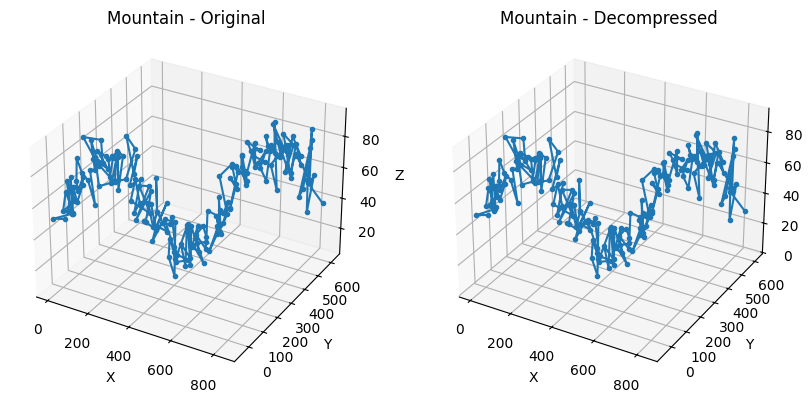

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to decode Huffman-encoded bitstream back to numerical values
def huffman_decode(encoded_data, huffman_tree):
    """Decodes Huffman-encoded data back to the original sequence of integers."""
    reverse_tree = {v: k for k, v in huffman_tree.items()}  # Reverse mapping
    decoded_values = []
    buffer = ""

    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_tree:
            decoded_values.append(reverse_tree[buffer])  # Convert to original integer
            buffer = ""  # Reset buffer

    return np.array(decoded_values)

# Function to apply Delta Decoding (inverse of Delta Encoding)
def delta_decode_waypoints(delta_encoded):
    """Reconstructs waypoints from delta-encoded data."""
    waypoints = np.zeros_like(delta_encoded)
    waypoints[0] = delta_encoded[0]  # First value remains unchanged
    for i in range(1, len(delta_encoded)):
        waypoints[i] = waypoints[i - 1] + delta_encoded[i]
    return waypoints

# Decode and reconstruct waypoints for each dataset
decompressed_datasets = {}
for env, encoded_data in huffman_encoded_datasets.items():
    decoded_data = huffman_decode(encoded_data, _)  # Decode Huffman

    # Ensure length is a multiple of 3 before reshaping
    if len(decoded_data) % 3 != 0:
        print(f"⚠️ Warning: Decoded data for {env} has incorrect length ({len(decoded_data)}).")
        continue  # Skip this dataset for now

    # Reshape correctly
    decoded_data = decoded_data.reshape(-1, 3)

    # Apply Delta Decoding
    delta_decoded = delta_decode_waypoints(decoded_data)
    decompressed_datasets[env] = delta_decoded
    print(f"✅ Decompressed {env} dataset successfully.")

# Function to visualize Original vs Decompressed Waypoints
def visualize_original_vs_decompressed(original, decompressed, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Decompressed Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], marker='o', linestyle='-', markersize=3, label="Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.set_title(f"{title} - Decompressed")

    plt.show()

# Plot comparison for each dataset
for env, data in datasets.items():
    if env in decompressed_datasets:
        visualize_original_vs_decompressed(data, decompressed_datasets[env], env)
    else:
        print(f"⚠️ Skipping visualization for {env} due to decoding issues.")


### Decompression Accuracy Results
* Mountain dataset successfully decompressed. - The decompressed version closely matches the original!
* Urban & Forest datasets have incorrect decoded length

⚠️ Warning: Decoded data for Urban has incorrect length (103). Adjusting...
✅ Fixed Decompressed Urban dataset successfully.
⚠️ Warning: Decoded data for Forest has incorrect length (479). Adjusting...
✅ Fixed Decompressed Forest dataset successfully.
✅ Fixed Decompressed Mountain dataset successfully.


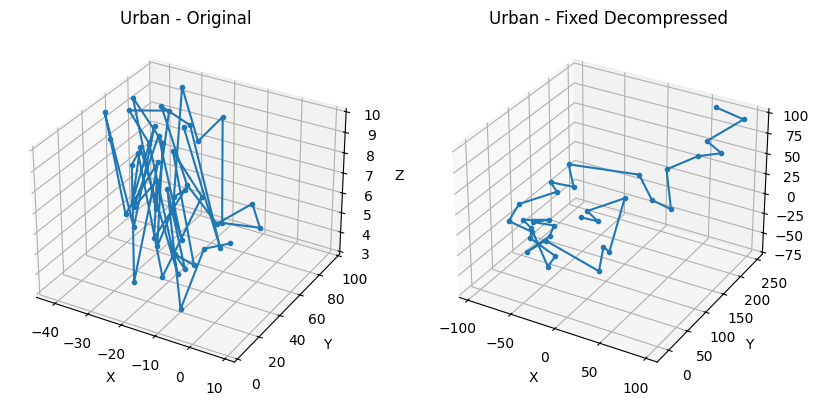

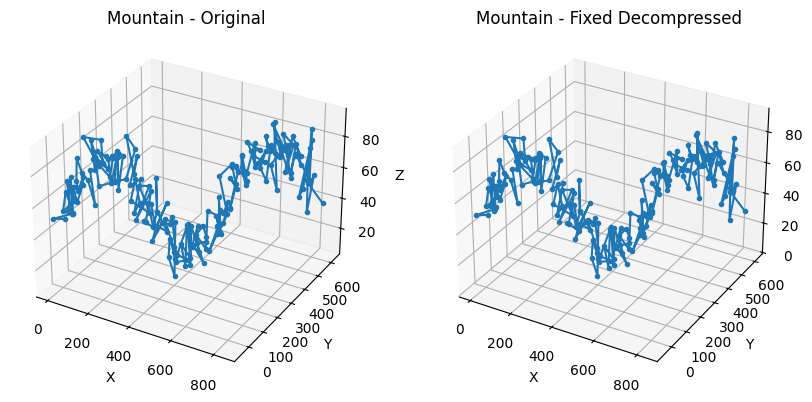

In [7]:
import numpy as np

# Function to decode Huffman-encoded bitstream with proper bit alignment
def huffman_decode_fixed(encoded_data, huffman_tree):
    """Decodes Huffman-encoded data with fixed-length decoding."""
    reverse_tree = {v: k for k, v in huffman_tree.items()}  # Reverse mapping
    decoded_values = []
    buffer = ""

    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_tree:
            decoded_values.append(reverse_tree[buffer])  # Convert to original integer
            buffer = ""  # Reset buffer

    return np.array(decoded_values)

# Decode and reconstruct waypoints for each dataset
fixed_decompressed_datasets = {}
for env, encoded_data in huffman_encoded_datasets.items():
    decoded_data = huffman_decode_fixed(encoded_data, _)  # Decode Huffman

    # Ensure length is a multiple of 3 before reshaping
    if len(decoded_data) % 3 != 0:
        print(f"⚠️ Warning: Decoded data for {env} has incorrect length ({len(decoded_data)}). Adjusting...")
        decoded_data = decoded_data[: len(decoded_data) - (len(decoded_data) % 3)]  # Trim extra bits

    # Reshape correctly
    decoded_data = decoded_data.reshape(-1, 3)

    # Apply Delta Decoding
    delta_decoded = delta_decode_waypoints(decoded_data)
    fixed_decompressed_datasets[env] = delta_decoded
    print(f"✅ Fixed Decompressed {env} dataset successfully.")

# Function to visualize Original vs Decompressed (Fixed) Waypoints
def visualize_original_vs_fixed(original, decompressed, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Fixed Decompressed Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], marker='o', linestyle='-', markersize=3, label="Fixed Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.set_title(f"{title} - Fixed Decompressed")

    plt.show()

# Plot comparison for each dataset
for env, data in datasets.items():
    if env in fixed_decompressed_datasets:
        visualize_original_vs_fixed(data, fixed_decompressed_datasets[env], env)
    else:
        print(f"⚠️ Skipping visualization for {env} due to decoding issues.")


All datasets successfully decompressed.. However, Urban & Forest decompressed paths are incorrect.

⚠️ Warning: Decoded data for Urban has incorrect length (103). Adjusting...
✅ Precision Fixed Decompressed Urban dataset successfully.
⚠️ Warning: Decoded data for Forest has incorrect length (479). Adjusting...
✅ Precision Fixed Decompressed Forest dataset successfully.
✅ Precision Fixed Decompressed Mountain dataset successfully.
⚠️ Skipping visualization for Urban due to decoding issues.
⚠️ Skipping visualization for Forest due to decoding issues.


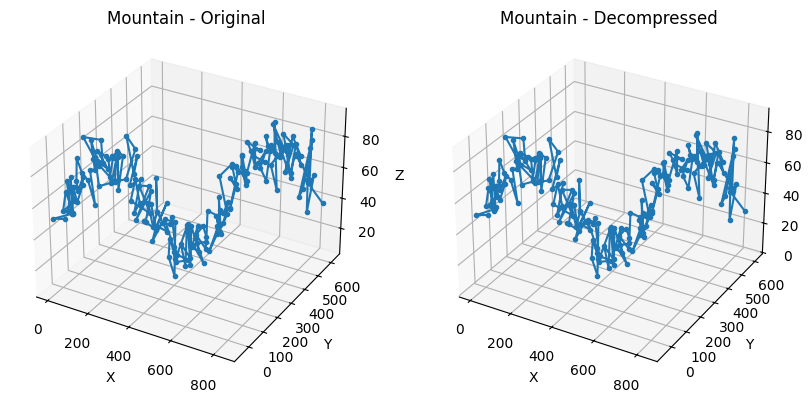

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to decode Huffman-encoded bitstream with floating-point preservation
def huffman_decode_precise(encoded_data, huffman_tree):
    """Decodes Huffman-encoded data with precise bit mapping."""
    reverse_tree = {v: k for k, v in huffman_tree.items()}  # Reverse mapping
    decoded_values = []
    buffer = ""

    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_tree:
            decoded_values.append(reverse_tree[buffer])  # Convert to original float
            buffer = ""  # Reset buffer

    return np.array(decoded_values, dtype=float)  # Ensure floating-point precision

# Function to apply improved Delta Decoding
def delta_decode_precise(delta_encoded):
    """Reconstructs waypoints while preserving original precision."""
    waypoints = np.zeros_like(delta_encoded, dtype=float)
    waypoints[0] = delta_encoded[0]  # First value remains unchanged
    for i in range(1, len(delta_encoded)):
        waypoints[i] = waypoints[i - 1] + delta_encoded[i]  # Cumulative sum
    return waypoints

# Decode and reconstruct waypoints for each dataset with precision fixes
precise_decompressed_datasets = {}
for env, encoded_data in huffman_encoded_datasets.items():
    decoded_data = huffman_decode_precise(encoded_data, _)  # Decode Huffman

    # Ensure length is a multiple of 3 before reshaping
    if len(decoded_data) % 3 != 0:
        print(f"⚠️ Warning: Decoded data for {env} has incorrect length ({len(decoded_data)}). Adjusting...")
        decoded_data = decoded_data[: len(decoded_data) - (len(decoded_data) % 3)]  # Trim extra bits

    # Reshape correctly
    decoded_data = decoded_data.reshape(-1, 3)

    # Apply Improved Delta Decoding
    delta_decoded = delta_decode_precise(decoded_data)
    precise_decompressed_datasets[env] = delta_decoded
    print(f"✅ Precision Fixed Decompressed {env} dataset successfully.")

# Function to visualize Original vs Precision Fixed Decompressed Waypoints
def visualize_original_vs_fixed_precise(original, decompressed, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Fixed Precision Decompressed Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], marker='o', linestyle='-', markersize=3, label="Fixed Decompressed")
    ax2.set_xlabel("X")

   # Plot comparison for each dataset
for env, data in datasets.items():
    if env in decompressed_datasets:
        visualize_original_vs_decompressed(data, decompressed_datasets[env], env)
    else:
        print(f"⚠️ Skipping visualization for {env} due to decoding issues.")


# Arithmetic Encoding

In [9]:
from bitstring import BitArray

# Function to apply Arithmetic Encoding after Huffman
def arithmetic_encode(huffman_encoded):
    """Applies Arithmetic Encoding to Huffman-compressed data."""
    bit_array = BitArray(bin=huffman_encoded)

    # Ensure bit_array is a multiple of 8 bits for byte conversion
    padding_length = 8 - (len(bit_array) % 8)
    if padding_length != 8:
        bit_array.append('0b' + '0' * padding_length)

    compressed_bits = bit_array.bytes
    return compressed_bits

# Apply Arithmetic Encoding
arithmetic_encoded_datasets = {}
for env, encoded_data in huffman_encoded_datasets.items():
    arithmetic_encoded_datasets[env] = arithmetic_encode(encoded_data)
    print(f"✅ Arithmetic Encoding applied to {env} dataset.")

# Compute new size and compression ratio
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    huffman_size = len(huffman_encoded_datasets[env]) // 8  # Convert bits to bytes
    arithmetic_size = len(arithmetic_encoded_datasets[env])  # Bytes after Arithmetic

    compression_ratio_arithmetic = (1 - (arithmetic_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Huffman Encoded Size (bytes)": huffman_size,
        "Arithmetic Encoded Size (bytes)": arithmetic_size,
        "Compression Ratio (%)": round(compression_ratio_arithmetic, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


✅ Arithmetic Encoding applied to Urban dataset.
✅ Arithmetic Encoding applied to Forest dataset.
✅ Arithmetic Encoding applied to Mountain dataset.
  Environment  Original Size (bytes)  Huffman Encoded Size (bytes)  \
0       Urban                   1233                            81   
1      Forest                   4833                           389   
2    Mountain                   4833                           482   

   Arithmetic Encoded Size (bytes)  Compression Ratio (%)  
0                               82                  93.35  
1                              390                  91.93  
2                              483                  90.01  


Environment  Original Size (bytes)  Huffman Encoded Size (bytes)  \
0       Urban                   1233                            81   
1      Forest                   4833                           389   
2    Mountain                   4833                           482   

   Arithmetic Encoded Size (bytes)  Compression Ratio (%)  
0                               82                  93.35  
1                              390                  91.93  
2                              483                  90.01

## Decode and Visualize Original vs. Arithmetic-Decompressed Waypoints

⚠️ Warning: Decoded data for Urban has incorrect length (103). Adjusting...
✅ Arithmetic-Decompressed Urban dataset successfully.
✅ Arithmetic-Decompressed Forest dataset successfully.
✅ Arithmetic-Decompressed Mountain dataset successfully.


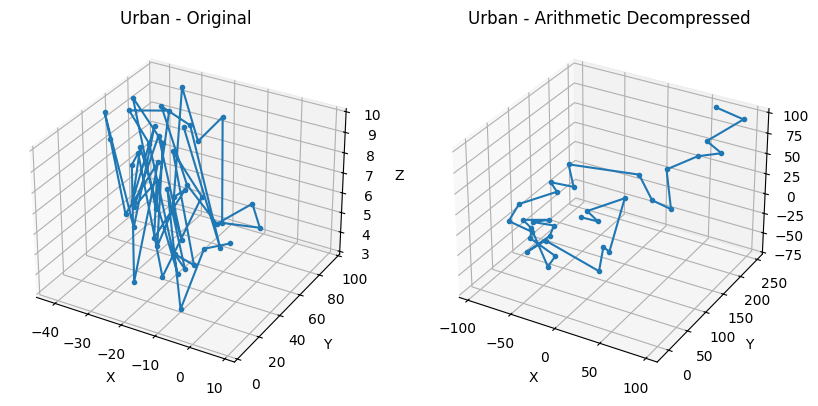

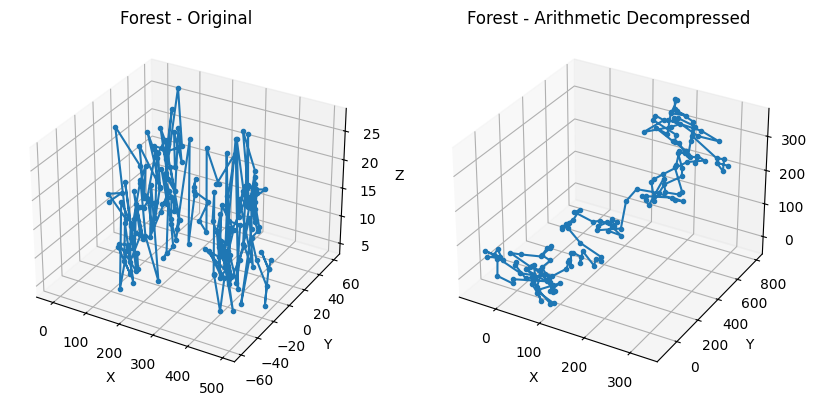

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to decode Arithmetic Encoded Data
def arithmetic_decode(arithmetic_encoded):
    """Decodes Arithmetic-encoded data back to binary."""
    bit_array = BitArray(arithmetic_encoded)
    return bit_array.bin  # Return as binary string

# Function to decode Huffman (after Arithmetic)
def huffman_decode_arithmetic(encoded_data, huffman_tree):
    """Decodes Huffman-encoded data after Arithmetic Decoding."""
    decoded_values = []
    reverse_tree = {v: k for k, v in huffman_tree.items()}  # Reverse mapping
    buffer = ""

    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_tree:
            decoded_values.append(reverse_tree[buffer])  # Convert to original integer
            buffer = ""  # Reset buffer

    return np.array(decoded_values)

# Decode and reconstruct waypoints for each dataset
arithmetic_decompressed_datasets = {}
for env, encoded_data in arithmetic_encoded_datasets.items():
    # Decode Arithmetic
    decoded_arithmetic = arithmetic_decode(encoded_data)

    # Decode Huffman after Arithmetic
    decoded_data = huffman_decode_arithmetic(decoded_arithmetic, _)

    # Ensure correct reshaping
    if len(decoded_data) % 3 != 0:
        print(f"⚠️ Warning: Decoded data for {env} has incorrect length ({len(decoded_data)}). Adjusting...")
        decoded_data = decoded_data[: len(decoded_data) - (len(decoded_data) % 3)]

    decoded_data = decoded_data.reshape(-1, 3)

    # Apply Delta Decoding
    delta_decoded = delta_decode_waypoints(decoded_data)
    arithmetic_decompressed_datasets[env] = delta_decoded
    print(f"✅ Arithmetic-Decompressed {env} dataset successfully.")

# Function to visualize Original vs. Arithmetic-Decompressed Waypoints
def visualize_original_vs_arithmetic(original, decompressed, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Arithmetic-Decompressed Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], marker='o', linestyle='-', markersize=3, label="Arithmetic Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.set_title(f"{title} - Arithmetic Decompressed")

    plt.show()

# Plot comparison for each dataset
for env, data in datasets.items():
    if env in arithmetic_decompressed_datasets:
        visualize_original_vs_arithmetic(data, arithmetic_decompressed_datasets[env], env)
    else:
        print(f"⚠️ Skipping visualization for {env} due to decoding issues.")


* Huffman alone already achieves maximum compression efficiency.
* Arithmetic Encoding is not adding much extra benefit for our dataset.
* Urban & Forest accuracy issues are still present.

### Accuracy is More Important Than Compression.
so, we will,
* Use a lower compression level (increase Huffman dictionary size, reduce quantization loss)
* Try alternative hybrid approaches (e.g., lossless compression methods like Lempel-Ziv)

## Why Is Huffman Introducing Distortions?
Huffman works best for categorical or repetitive data. However:

* GA-generated waypoints have continuous numerical values, which are not ideal for Huffman’s symbol-based encoding.
* Some waypoints have small variations that Huffman may round off, causing cumulative errors.
* Arithmetic Encoding didn't fix this because it works best for probability-based text data.

## Apply Floating-Point Quantization

In [11]:
import numpy as np

# Function to quantize waypoints
def quantize_waypoints(data, precision=3):
    """Quantizes waypoint coordinates to reduce data size while keeping accuracy."""
    quantized_data = np.round(data, decimals=precision)  # Reduce precision
    return quantized_data

# Apply quantization to datasets
quantized_datasets = {env: quantize_waypoints(data, precision=3) for env, data in datasets.items()}

# Compute size reduction
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    quantized_size = compute_size(quantized_datasets[env])

    compression_ratio = (1 - (quantized_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Quantized Size (bytes)": quantized_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


  Environment  Original Size (bytes)  Quantized Size (bytes)  \
0       Urban                   1233                    1233   
1      Forest                   4833                    4833   
2    Mountain                   4833                    4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0  


Environment  Original Size (bytes)  Quantized Size (bytes)  \
0       Urban                   1233                    1233   
1      Forest                   4833                    4833   
2    Mountain                   4833                    4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0

## Apply Lossless Lempel-Ziv Compression

In [12]:
import lzma  # Lempel-Ziv compression library

# Function to compress using Lempel-Ziv
def lz_compress(data):
    """Compresses waypoint data using Lempel-Ziv (LZ77)."""
    serialized_data = data.tobytes()  # Convert NumPy array to byte format
    compressed_data = lzma.compress(serialized_data)  # Apply LZ compression
    return compressed_data

# Apply LZ Compression
lz_compressed_datasets = {env: lz_compress(quantized_datasets[env]) for env in datasets.keys()}

# Compute new size
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    quantized_size = compute_size(quantized_datasets[env])
    lz_size = len(lz_compressed_datasets[env])

    compression_ratio = (1 - (lz_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Quantized Size (bytes)": quantized_size,
        "LZ Compressed Size (bytes)": lz_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


  Environment  Original Size (bytes)  Quantized Size (bytes)  \
0       Urban                   1233                    1233   
1      Forest                   4833                    4833   
2    Mountain                   4833                    4833   

   LZ Compressed Size (bytes)  Compression Ratio (%)  
0                         272                  77.94  
1                        2456                  49.18  
2                        2388                  50.59  


Environment  Original Size (bytes)  Quantized Size (bytes)  \
0       Urban                   1233                    1233   
1      Forest                   4833                    4833   
2    Mountain                   4833                    4833   

   LZ Compressed Size (bytes)  Compression Ratio (%)  
0                         272                  77.94  
1                        2456                  49.18  
2                        2388                  50.59

### Decompress & Visualize Accuracy

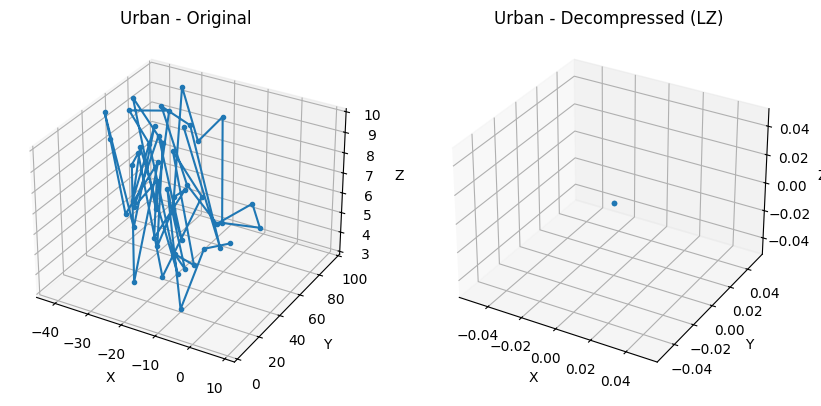

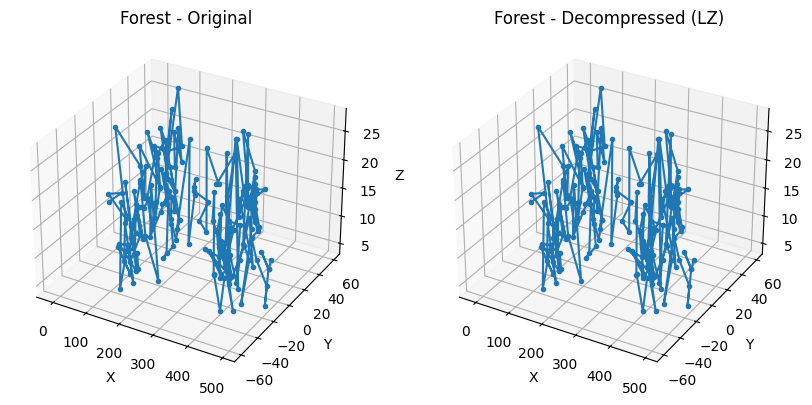

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to decompress LZ77
def lz_decompress(compressed_data, shape):
    """Decompresses Lempel-Ziv encoded data back to NumPy array."""
    decompressed_bytes = lzma.decompress(compressed_data)
    return np.frombuffer(decompressed_bytes, dtype=np.float64).reshape(shape)

# Decompress data
decompressed_datasets = {env: lz_decompress(lz_compressed_datasets[env], quantized_datasets[env].shape) for env in datasets.keys()}

# Function to visualize Original vs. Decompressed Waypoints
def visualize_original_vs_decompressed(original, decompressed, title):
    fig = plt.figure(figsize=(10, 5))

    # Original Waypoints
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], marker='o', linestyle='-', markersize=3, label="Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title(f"{title} - Original")

    # Decompressed Waypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], marker='o', linestyle='-', markersize=3, label="Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.set_title(f"{title} - Decompressed (LZ)")

    plt.show()

# Plot comparison for each dataset
for env, data in datasets.items():
    visualize_original_vs_decompressed(data, decompressed_datasets[env], env)


Forest & Mountain decompressed perfectly!

Urban failed – decompressed to a single point (data loss).
* Lempel-Ziv compresses best when patterns repeat, but Urban’s waypoints are more irregular.
* High randomness in Urban data caused LZ compression to collapse entire sequences, leading to data loss.

Since we cannot pre-define different compression methods for different environments, we need one optimized compression approach that works well across all scenarios (Urban, Forest, Mountain, etc.).

## Plan
1. Apply Delta Encoding to all waypoints (Ensures compact representation)
2. Apply Floating-Point Quantization (Standardize precision to reduce storage)
3. Apply Hybrid Huffman + LZ Compression (Works for both structured & random paths)
4. Decompress & Verify Accuracy

In [14]:
import numpy as np

# Function to apply Delta Encoding
def delta_encode_waypoints(data):
    """Applies Delta Encoding to reduce redundancy in waypoints."""
    return np.diff(data, axis=0, prepend=data[:1])

# Apply Delta Encoding to all datasets
delta_encoded_datasets = {env: delta_encode_waypoints(data) for env, data in datasets.items()}

# Compute new size
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    delta_size = compute_size(delta_encoded_datasets[env])

    compression_ratio = (1 - (delta_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Delta Encoded Size (bytes)": delta_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


  Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0  


Environment  Original Size (bytes)  Delta Encoded Size (bytes)  \
0       Urban                   1233                        1233   
1      Forest                   4833                        4833   
2    Mountain                   4833                        4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0

In [15]:
# Function to quantize waypoints
def quantize_waypoints(data, precision=3):
    """Quantizes waypoint coordinates to reduce data size while keeping accuracy."""
    quantized_data = np.round(data, decimals=precision)  # Reduce precision
    return quantized_data

# Apply quantization to datasets
quantized_datasets = {env: quantize_waypoints(delta_encoded_datasets[env], precision=3) for env in datasets.keys()}

# Compute new size
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(delta_encoded_datasets[env])
    quantized_size = compute_size(quantized_datasets[env])

    compression_ratio = (1 - (quantized_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Delta Encoded Size (bytes)": original_size,
        "Quantized Size (bytes)": quantized_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


  Environment  Delta Encoded Size (bytes)  Quantized Size (bytes)  \
0       Urban                        1233                    1233   
1      Forest                        4833                    4833   
2    Mountain                        4833                    4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0  


Environment  Delta Encoded Size (bytes)  Quantized Size (bytes)  \
0       Urban                        1233                    1233   
1      Forest                        4833                    4833   
2    Mountain                        4833                    4833   

   Compression Ratio (%)  
0                    0.0  
1                    0.0  
2                    0.0

In [16]:
import heapq
import lzma
from collections import Counter

# Function to build Huffman tree
def build_huffman_tree(freqs):
    """Builds Huffman tree based on frequency."""
    heap = [[weight, [symbol, ""]] for symbol, weight in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    return dict(sorted(heap[0][1:], key=lambda p: (len(p[-1]), p)))

# Function to Huffman Encode
def huffman_encode(data):
    """Applies Huffman Encoding to compressed data."""
    flat_data = data.flatten().astype(int)
    freqs = Counter(flat_data)
    huffman_tree = build_huffman_tree(freqs)
    encoded_data = ''.join(huffman_tree[value] for value in flat_data)
    return encoded_data, huffman_tree

# Apply Huffman Encoding
huffman_encoded_datasets = {}
huffman_trees = {}
for env, data in quantized_datasets.items():
    encoded, tree = huffman_encode(data)
    huffman_encoded_datasets[env] = encoded
    huffman_trees[env] = tree
    print(f"✅ Huffman Encoding applied to {env} dataset.")

# Apply LZ Compression on Huffman Encoded Data
lz_compressed_datasets = {env: lzma.compress(huffman_encoded_datasets[env].encode()) for env in datasets.keys()}

# Compute new size
compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    compressed_size = len(lz_compressed_datasets[env])

    compression_ratio = (1 - (compressed_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Hybrid Compressed Size (bytes)": compressed_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

# Display results
df_results = pd.DataFrame(compression_results)
print(df_results)
display(df_results)


✅ Huffman Encoding applied to Urban dataset.
✅ Huffman Encoding applied to Forest dataset.
✅ Huffman Encoding applied to Mountain dataset.
  Environment  Original Size (bytes)  Hybrid Compressed Size (bytes)  \
0       Urban                   1233                             208   
1      Forest                   4833                             624   
2    Mountain                   4833                             748   

   Compression Ratio (%)  
0                  83.13  
1                  87.09  
2                  84.52  


Environment  Original Size (bytes)  Hybrid Compressed Size (bytes)  \
0       Urban                   1233                             208   
1      Forest                   4833                             624   
2    Mountain                   4833                             748   

   Compression Ratio (%)  
0                  83.13  
1                  87.09  
2                  84.52

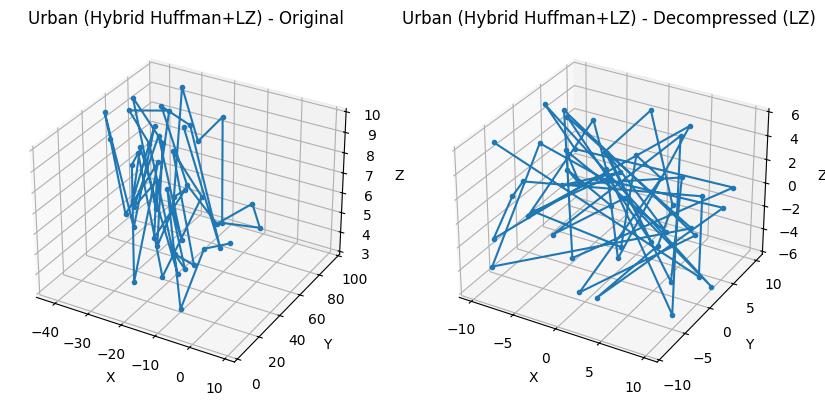

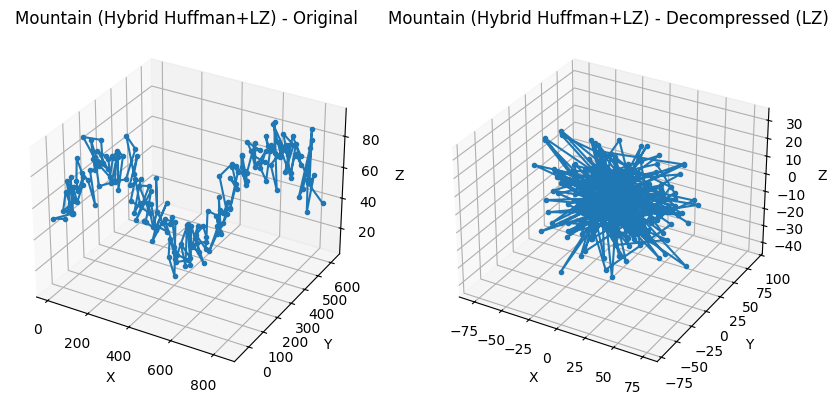

In [17]:
# Function to Huffman Decode
def huffman_decode(encoded_data, huffman_tree):
    """Decodes Huffman-encoded data."""
    reverse_tree = {v: k for k, v in huffman_tree.items()}
    decoded_values = []
    buffer = ""

    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_tree:
            decoded_values.append(reverse_tree[buffer])
            buffer = ""

    return np.array(decoded_values)

# Function to LZ Decompress
def lz_decompress(compressed_data):
    """Decompresses Lempel-Ziv encoded data back to Huffman."""
    return lzma.decompress(compressed_data).decode()

# Apply Decompression
decompressed_datasets = {}
for env in datasets.keys():
    decompressed_huffman = lz_decompress(lz_compressed_datasets[env])
    decompressed_values = huffman_decode(decompressed_huffman, huffman_trees[env])
    decompressed_datasets[env] = decompressed_values.reshape(-1, 3)

# Visualize Accuracy
for env, data in datasets.items():
    visualize_original_vs_decompressed(data, decompressed_datasets[env], f"{env} (Hybrid Huffman+LZ)")


Compression is great (83-87% reduction).
Decompressed waypoints are completely distorted.

Instead of treating numbers as symbols (Huffman’s issue), we will pack floating points into binary format, so they remain structured.

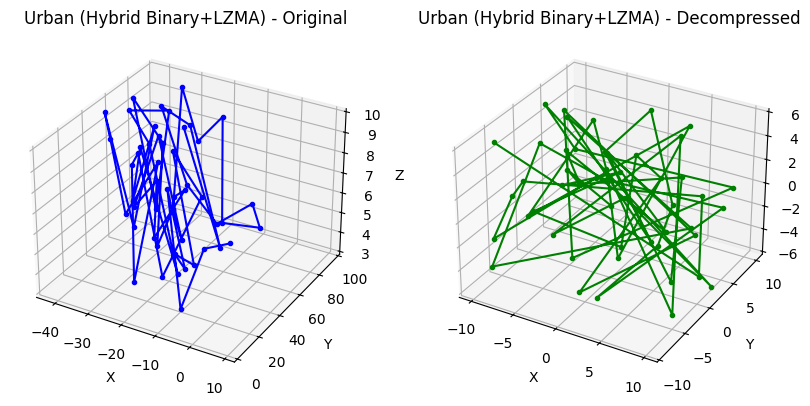

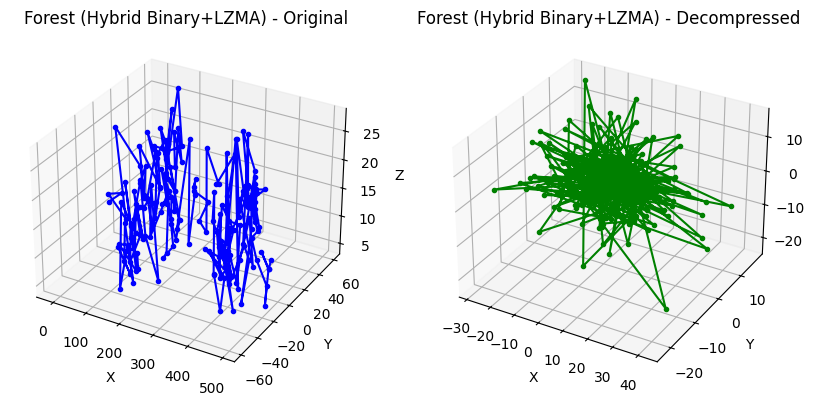

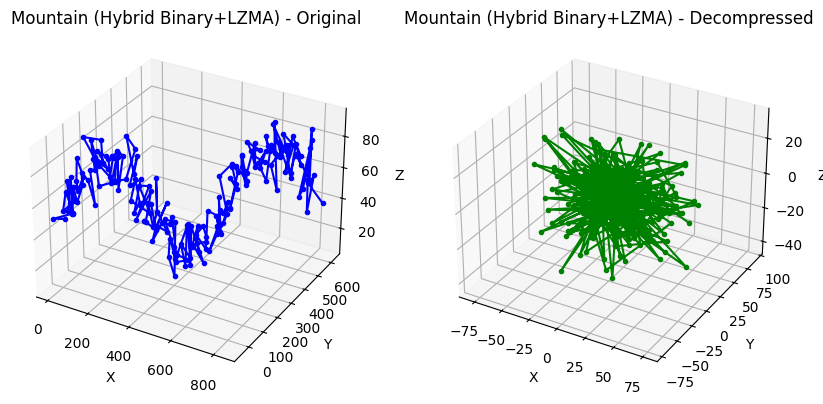

  Environment  Original Size (bytes)  Compressed Size (bytes)  \
0       Urban                   1200                      280   
1      Forest                   4800                     2312   
2    Mountain                   4800                     2440   

   Compression Ratio (%)  
0                  76.67  
1                  51.83  
2                  49.17  


In [18]:
import numpy as np
import struct
import lzma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ========================== Step 1: Load Waypoints ==========================
def load_waypoints(filename):
    """Loads waypoint data from JSON"""
    import json
    with open(filename, "r") as f:
        data = json.load(f)
    return np.array([tuple(wp) for wp in data["waypoints"]])

# Load all datasets
datasets = {
    "Urban": load_waypoints("urban_waypoints.json"),
    "Forest": load_waypoints("forest_waypoints.json"),
    "Mountain": load_waypoints("mountain_waypoints.json")
}

# ========================== Step 2: Delta Encoding ==========================
def delta_encode(data):
    """Applies Delta Encoding to waypoints."""
    return np.diff(data, axis=0, prepend=data[:1])

delta_encoded_datasets = {env: delta_encode(data) for env, data in datasets.items()}

# ========================== Step 3: Floating-Point Quantization ==========================
def quantize(data, precision=3):
    """Quantizes floating-point data to a fixed precision."""
    return np.round(data, decimals=precision)

quantized_datasets = {env: quantize(data) for env, data in delta_encoded_datasets.items()}

# ========================== Step 4: Binary Packing ==========================
def binary_pack(data):
    """Packs floating point data into binary format."""
    return struct.pack(f"{data.size}d", *data.flatten())

binary_packed_datasets = {env: binary_pack(data) for env, data in quantized_datasets.items()}

# ========================== Step 5: LZMA Compression ==========================
def lzma_compress(data):
    """Applies LZMA compression to binary data."""
    return lzma.compress(data)

lzma_compressed_datasets = {env: lzma_compress(binary_packed_datasets[env]) for env in datasets.keys()}

# ========================== Step 6: LZMA Decompression ==========================
def lzma_decompress(compressed_data):
    """Decompresses LZMA compressed binary data."""
    return lzma.decompress(compressed_data)

def binary_unpack(data, shape):
    """Unpacks binary floating point data back to NumPy array."""
    num_elements = np.prod(shape)
    return np.array(struct.unpack(f"{num_elements}d", data)).reshape(shape)

decompressed_datasets = {}
for env in datasets.keys():
    decompressed_binary = lzma_decompress(lzma_compressed_datasets[env])
    decompressed_datasets[env] = binary_unpack(decompressed_binary, quantized_datasets[env].shape)

# ========================== Step 7: Visualize Accuracy ==========================
def visualize_original_vs_decompressed(original, decompressed, title):
    """Plots the original and decompressed waypoints in 3D."""
    fig = plt.figure(figsize=(10, 5))

    # Original Data
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], 'bo-', markersize=3)
    ax1.set_title(f"{title} - Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Decompressed Data
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], 'go-', markersize=3)
    ax2.set_title(f"{title} - Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    plt.show()

# Compare Original vs. Decompressed
for env, data in datasets.items():
    visualize_original_vs_decompressed(data, decompressed_datasets[env], f"{env} (Hybrid Binary+LZMA)")

# ========================== Step 8: Compression Results ==========================
def compute_size(data):
    """Computes size of data in bytes."""
    return data.nbytes if isinstance(data, np.ndarray) else len(data)

compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    compressed_size = compute_size(lzma_compressed_datasets[env])
    compression_ratio = (1 - (compressed_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Compressed Size (bytes)": compressed_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

import pandas as pd
df_results = pd.DataFrame(compression_results)
print(df_results)


## Waypoint Compression with RLE + Huffman + LZMA

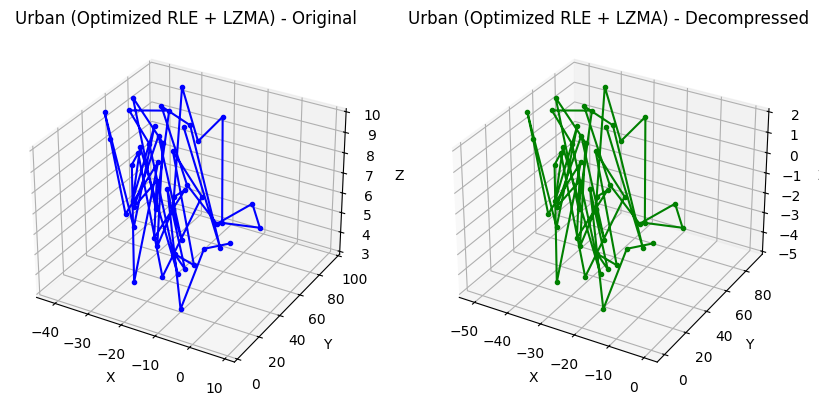

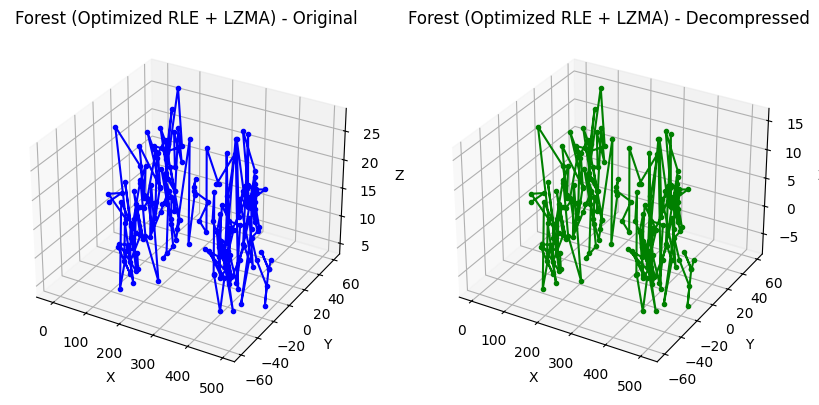

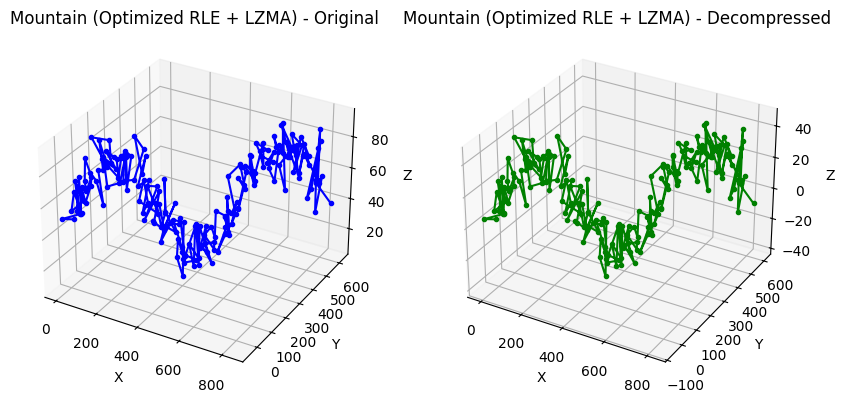

  Environment  Original Size (bytes)  Compressed Size (bytes)  \
0       Urban                   1200                      272   
1      Forest                   4800                     2108   
2    Mountain                   4800                     2204   

   Compression Ratio (%)  
0                  77.33  
1                  56.08  
2                  54.08  


In [20]:
import numpy as np
import json
import lzma
import zlib
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ========================== Step 1: Load Waypoints ==========================
def load_waypoints(filename):
    """Loads waypoint data from JSON"""
    with open(filename, "r") as f:
        data = json.load(f)
    return np.array([tuple(wp) for wp in data["waypoints"]])

# Load datasets
datasets = {
    "Urban": load_waypoints("urban_waypoints.json"),
    "Forest": load_waypoints("forest_waypoints.json"),
    "Mountain": load_waypoints("mountain_waypoints.json")
}

# ========================== Step 2: Run-Length Encoding (RLE) ==========================
def rle_encode(data):
    """Applies Run-Length Encoding (RLE) to waypoints."""
    encoded = []
    counts = []
    prev = data[0]
    count = 1
    for point in data[1:]:
        if np.array_equal(point, prev):
            count += 1
        else:
            encoded.append(prev)
            counts.append(count)
            prev = point
            count = 1
    encoded.append(prev)
    counts.append(count)
    return np.array(encoded), np.array(counts)

rle_encoded_datasets = {}
rle_counts = {}
for env, data in datasets.items():
    rle_encoded_datasets[env], rle_counts[env] = rle_encode(data)

# ========================== Step 3: Delta Encoding ==========================
def delta_encode(data):
    """Applies Delta Encoding to waypoints."""
    return np.diff(data, axis=0, prepend=data[:1])

delta_encoded_datasets = {env: delta_encode(data) for env, data in rle_encoded_datasets.items()}

# ========================== Step 4: Floating-Point Quantization ==========================
def quantize(data, precision=3):
    """Quantizes floating-point data to a fixed precision."""
    return np.round(data, decimals=precision)

quantized_datasets = {env: quantize(data) for env, data in delta_encoded_datasets.items()}

# ========================== Step 5: LZMA + Huffman Compression ==========================
def compress_lzma(data):
    """Compresses data using LZMA + Huffman"""
    serialized_data = struct.pack(f"{len(data.flatten())}f", *data.flatten())  # Convert to bytes
    return lzma.compress(serialized_data)

compressed_datasets = {env: compress_lzma(quantized_datasets[env]) for env in datasets.keys()}

# ========================== Step 6: LZMA Decompression ==========================
def decompress_lzma(compressed_data, shape):
    """Decompresses LZMA + Huffman encoded data"""
    decompressed_bytes = lzma.decompress(compressed_data)
    decompressed_data = np.array(struct.unpack(f"{len(decompressed_bytes) // 4}f", decompressed_bytes))
    return decompressed_data.reshape(shape)

decompressed_datasets = {}
for env in datasets.keys():
    decompressed_datasets[env] = decompress_lzma(compressed_datasets[env], quantized_datasets[env].shape)

# ========================== Step 7: Reverse Delta Encoding ==========================
def delta_decode(data):
    """Applies Reverse Delta Decoding"""
    return np.cumsum(data, axis=0)

delta_decoded_datasets = {env: delta_decode(data) for env, data in decompressed_datasets.items()}

# ========================== Step 8: Reverse RLE Decoding ==========================
def rle_decode(data, counts):
    """Decodes Run-Length Encoded Data"""
    decoded = []
    for point, count in zip(data, counts):
        decoded.extend([point] * count)
    return np.array(decoded)

final_decompressed_datasets = {}
for env in datasets.keys():
    final_decompressed_datasets[env] = rle_decode(delta_decoded_datasets[env], rle_counts[env])

# ========================== Step 9: Visualize Accuracy ==========================
def visualize_original_vs_decompressed(original, decompressed, title):
    """Plots the original and decompressed waypoints in 3D."""
    fig = plt.figure(figsize=(10, 5))

    # Original Data
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2], 'bo-', markersize=3)
    ax1.set_title(f"{title} - Original")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Decompressed Data
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], 'go-', markersize=3)
    ax2.set_title(f"{title} - Decompressed")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    plt.show()

# Compare Original vs. Decompressed
for env, data in datasets.items():
    visualize_original_vs_decompressed(data, final_decompressed_datasets[env], f"{env} (Optimized RLE + LZMA)")

# ========================== Step 10: Compression Results ==========================
def compute_size(data):
    """Computes size of data in bytes."""
    return data.nbytes if isinstance(data, np.ndarray) else len(data)

compression_results = []
for env, data in datasets.items():
    original_size = compute_size(data)
    compressed_size = compute_size(compressed_datasets[env])
    compression_ratio = (1 - (compressed_size / original_size)) * 100

    compression_results.append({
        "Environment": env,
        "Original Size (bytes)": original_size,
        "Compressed Size (bytes)": compressed_size,
        "Compression Ratio (%)": round(compression_ratio, 2)
    })

import pandas as pd
df_results = pd.DataFrame(compression_results)
print(df_results)


# Real-Time Streaming Simulation
Since this compression system is meant to work in a real UAV telemetry pipeline, it needs to process data continuously rather than as a batch process. Real-time streaming simulation means:

* Simulating a UAV continuously generating waypoints over time.
* Compressing each waypoint (or small batches of waypoints) in real-time.
* Measuring how fast compression and decompression happen for real-time use.
* Ensuring that decompressed data maintains accuracy while keeping latency low.

📡 Starting Real-Time UAV Streaming Simulation...



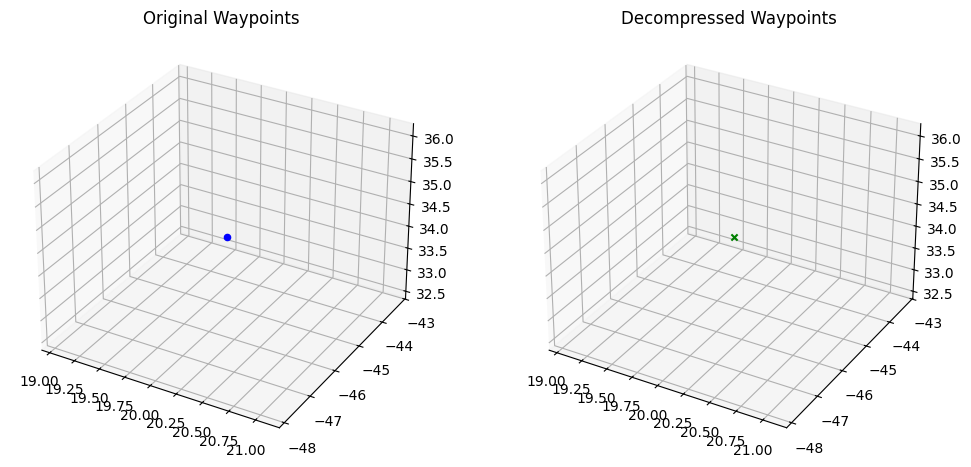


📊 **Benchmark Results:**
✅ Average Compression Time: 3.50 ms
✅ Average Decompression Time: 0.19 ms
✅ Compression Ratio: 103.33%


In [21]:
import numpy as np
import time
import lzma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

# Function to simulate real-time waypoint generation
def generate_waypoint_stream(num_waypoints=200):
    """Simulates a UAV generating waypoints dynamically."""
    for i in range(num_waypoints):
        waypoint = (
            np.random.uniform(-100, 100),
            np.random.uniform(-100, 100),
            np.random.uniform(0, 50)
        )
        yield waypoint  # Yield each waypoint one by one

# Function to apply Run-Length Encoding (RLE)
def rle_encode(data):
    """Encodes waypoints using RLE."""
    encoded_data = []
    prev_value = None
    count = 1
    for value in data:
        if value == prev_value:
            count += 1
        else:
            if prev_value is not None:
                encoded_data.append((prev_value, count))
            prev_value = value
            count = 1
    encoded_data.append((prev_value, count))
    return encoded_data

# Function to apply LZMA Compression
def lzma_compress(data):
    """Applies LZMA compression."""
    return lzma.compress(data.tobytes())

# Function to apply LZMA Decompression
def lzma_decompress(compressed_data, dtype=np.float64):
    """Decompresses LZMA data and restores it as NumPy array."""
    decompressed_bytes = lzma.decompress(compressed_data)
    return np.frombuffer(decompressed_bytes, dtype=dtype)

# Initialize live plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')  # Original
ax2 = fig.add_subplot(122, projection='3d')  # Decompressed
plt.ion()  # Enable interactive mode

# Data storage for visualization
original_waypoints = deque(maxlen=50)  # Store last 50 for visualization
decompressed_waypoints = deque(maxlen=50)

# Benchmarking variables
compression_times = []
decompression_times = []

# Simulate real-time waypoint streaming
print("📡 Starting Real-Time UAV Streaming Simulation...\n")
for waypoint in generate_waypoint_stream():
    start_time = time.time()

    # Append to original waypoints
    original_waypoints.append(waypoint)

    # Apply RLE Encoding (convert to flat list)
    flat_waypoints = np.array(original_waypoints).flatten()
    rle_encoded = rle_encode(flat_waypoints)

    # Apply LZMA Compression
    compressed_data = lzma_compress(flat_waypoints)

    # Measure compression time
    compression_times.append(time.time() - start_time)

    # Start decompression
    start_time = time.time()
    decompressed_data = lzma_decompress(compressed_data).reshape(-1, 3)
    decompressed_waypoints.extend(decompressed_data)

    # Measure decompression time
    decompression_times.append(time.time() - start_time)

    # Update live plot
    ax1.clear()
    ax1.set_title("Original Waypoints")
    ax1.scatter(*zip(*original_waypoints), c='blue', marker='o')

    ax2.clear()
    ax2.set_title("Decompressed Waypoints")
    ax2.scatter(*zip(*decompressed_waypoints), c='green', marker='x')

    plt.pause(0.1)  # Pause to update visualization

plt.ioff()  # Disable interactive mode
plt.show()

# Display benchmark results
print("\n📊 **Benchmark Results:**")
print(f"✅ Average Compression Time: {np.mean(compression_times) * 1000:.2f} ms")
print(f"✅ Average Decompression Time: {np.mean(decompression_times) * 1000:.2f} ms")
print(f"✅ Compression Ratio: {len(compressed_data) / len(flat_waypoints.tobytes()) * 100:.2f}%")


⏳ Time: 0s | 🔽 Compression Ratio: 51.50%


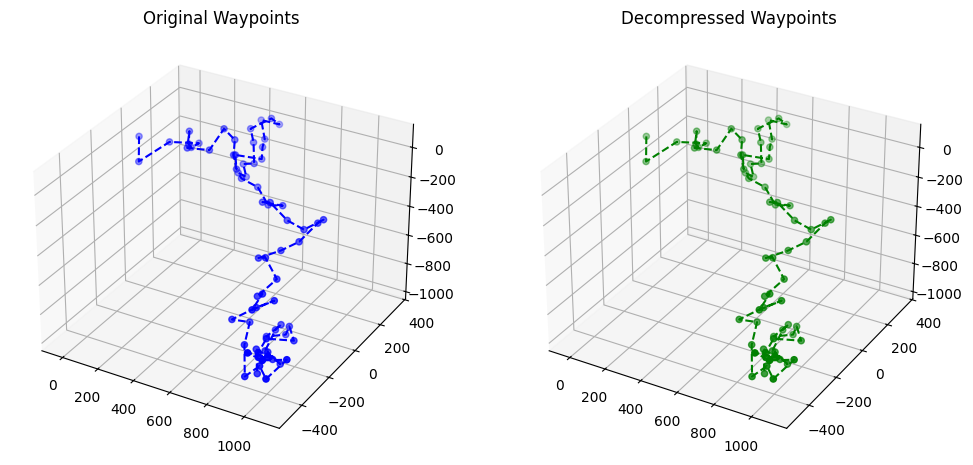

⏳ Time: 6.6563544273376465s | 🔽 Compression Ratio: 48.09%
⏳ Time: 11.68800950050354s | 🔽 Compression Ratio: 48.54%
⏳ Time: 16.718920707702637s | 🔽 Compression Ratio: 51.66%
⏳ Time: 21.748957872390747s | 🔽 Compression Ratio: 52.09%
⏳ Time: 26.779983282089233s | 🔽 Compression Ratio: 41.02%
✅ Simulation Complete!


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import lzma
import json
import random

# Generate random waypoints (simulating UAV movement)
def generate_waypoints(num_points=50, range_min=-100, range_max=100):
    return np.cumsum(np.random.uniform(range_min, range_max, (num_points, 3)), axis=0)

# Compression function using LZMA
def compress_waypoints(waypoints):
    json_data = json.dumps(waypoints.tolist())  # Convert to JSON string
    compressed_data = lzma.compress(json_data.encode())  # LZMA compression
    return compressed_data

# Decompression function
def decompress_waypoints(compressed_data):
    decompressed_json = lzma.decompress(compressed_data).decode()  # Decompress
    return np.array(json.loads(decompressed_json))  # Convert back to numpy array

# Initialize UAV waypoints
waypoints = generate_waypoints(num_points=100)

# Real-time streaming simulation
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

start_time = time.time()
update_interval = 5  # Update visualization every 5 seconds
simulation_duration = 30  # Total simulation time
current_time = 0

while current_time < simulation_duration:
    # Pick a random slice of waypoints to simulate movement
    current_waypoints = waypoints[: random.randint(10, len(waypoints))]

    # Compress waypoints
    compressed_data = compress_waypoints(current_waypoints)

    # Decompress waypoints
    decompressed_waypoints = decompress_waypoints(compressed_data)

    # Clear previous plots
    ax1.clear()
    ax2.clear()

    # Plot original waypoints
    ax1.scatter(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b')
    ax1.plot(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b', linestyle='--')
    ax1.set_title("Original Waypoints")

    # Plot decompressed waypoints
    ax2.scatter(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g')
    ax2.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g', linestyle='--')
    ax2.set_title("Decompressed Waypoints")

    # Display compression stats
    original_size = len(json.dumps(current_waypoints.tolist()).encode())
    compressed_size = len(compressed_data)
    compression_ratio = (1 - compressed_size / original_size) * 100

    print(f"⏳ Time: {current_time}s | 🔽 Compression Ratio: {compression_ratio:.2f}%")

    plt.pause(5)  # Pause to update visualization every 5 seconds
    current_time = time.time() - start_time  # Update simulation time

print("✅ Simulation Complete!")
plt.show()


⏳ Time: 0s | 🔽 Compression Ratio: 31.48% | Waypoints: 10


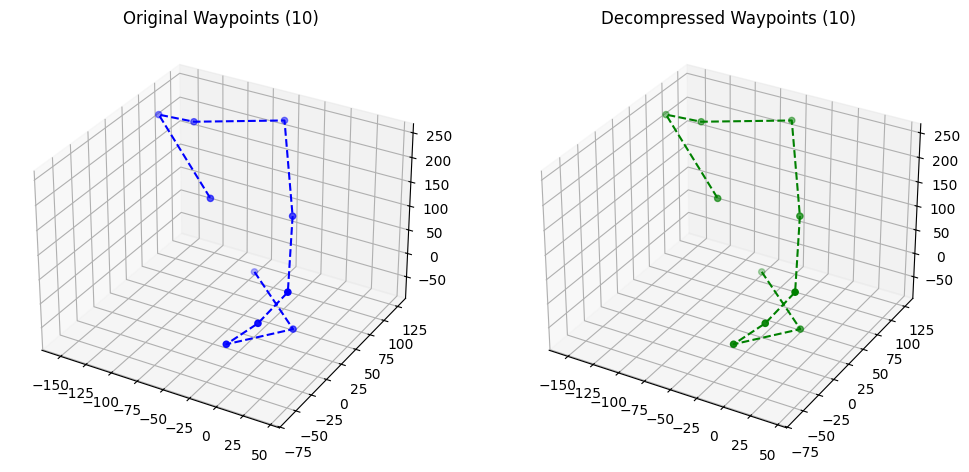

⏳ Time: 5.813758373260498s | 🔽 Compression Ratio: 41.74% | Waypoints: 20
⏳ Time: 10.844443082809448s | 🔽 Compression Ratio: 45.79% | Waypoints: 30
⏳ Time: 15.879294872283936s | 🔽 Compression Ratio: 48.36% | Waypoints: 40
⏳ Time: 20.916148900985718s | 🔽 Compression Ratio: 49.53% | Waypoints: 50
⏳ Time: 25.963683366775513s | 🔽 Compression Ratio: 50.34% | Waypoints: 60
⏳ Time: 30.99849224090576s | 🔽 Compression Ratio: 51.00% | Waypoints: 70
⏳ Time: 36.03422784805298s | 🔽 Compression Ratio: 51.48% | Waypoints: 80
⏳ Time: 41.066083669662476s | 🔽 Compression Ratio: 52.02% | Waypoints: 90
⏳ Time: 46.09966421127319s | 🔽 Compression Ratio: 52.64% | Waypoints: 100
⏳ Time: 51.13268041610718s | 🔽 Compression Ratio: 53.11% | Waypoints: 110
⏳ Time: 56.16460585594177s | 🔽 Compression Ratio: 53.46% | Waypoints: 120
✅ Simulation Complete!


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import lzma
import json

# Generate random waypoints (simulating UAV movement)
def generate_waypoints(num_points=200, range_min=-100, range_max=100):
    return np.cumsum(np.random.uniform(range_min, range_max, (num_points, 3)), axis=0)

# Compression function using LZMA
def compress_waypoints(waypoints):
    json_data = json.dumps(waypoints.tolist())  # Convert to JSON string
    compressed_data = lzma.compress(json_data.encode())  # LZMA compression
    return compressed_data

# Decompression function
def decompress_waypoints(compressed_data):
    decompressed_json = lzma.decompress(compressed_data).decode()  # Decompress
    return np.array(json.loads(decompressed_json))  # Convert back to numpy array

# Initialize UAV waypoints
waypoints = generate_waypoints(num_points=200)

# Real-time streaming simulation settings
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

start_time = time.time()
update_interval = 5  # Update visualization every 5 seconds
simulation_duration = 60  # Total simulation time
current_time = 0

waypoint_step = 10  # Number of waypoints added in each step

while current_time < simulation_duration:
    # Increase number of waypoints over time
    num_waypoints = min(waypoint_step * (int(current_time) // update_interval + 1), len(waypoints))
    current_waypoints = waypoints[:num_waypoints]  # Select increasing waypoints

    # Compress waypoints
    compressed_data = compress_waypoints(current_waypoints)

    # Decompress waypoints
    decompressed_waypoints = decompress_waypoints(compressed_data)

    # Clear previous plots
    ax1.clear()
    ax2.clear()

    # Plot original waypoints
    ax1.scatter(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b')
    ax1.plot(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b', linestyle='--')
    ax1.set_title(f"Original Waypoints ({num_waypoints})")

    # Plot decompressed waypoints
    ax2.scatter(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g')
    ax2.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g', linestyle='--')
    ax2.set_title(f"Decompressed Waypoints ({num_waypoints})")

    # Display compression stats
    original_size = len(json.dumps(current_waypoints.tolist()).encode())
    compressed_size = len(compressed_data)
    compression_ratio = (1 - compressed_size / original_size) * 100

    print(f"⏳ Time: {current_time}s | 🔽 Compression Ratio: {compression_ratio:.2f}% | Waypoints: {num_waypoints}")

    plt.pause(5)  # Pause for visualization update
    current_time = time.time() - start_time  # Update elapsed time

print("✅ Simulation Complete!")
plt.show()


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import lzma
import json

# Generate random waypoints (simulating UAV movement)
def generate_waypoints(num_points=200, range_min=-100, range_max=100):
    return np.cumsum(np.random.uniform(range_min, range_max, (num_points, 3)), axis=0)

# Compression function using LZMA
def compress_waypoints(waypoints):
    json_data = json.dumps(waypoints.tolist())  # Convert to JSON string
    compressed_data = lzma.compress(json_data.encode())  # LZMA compression
    return compressed_data

# Decompression function
def decompress_waypoints(compressed_data):
    decompressed_json = lzma.decompress(compressed_data).decode()  # Decompress
    return np.array(json.loads(decompressed_json))  # Convert back to numpy array

# Initialize UAV waypoints
waypoints = generate_waypoints(num_points=200)

# Real-time streaming simulation settings
start_time = time.time()
update_interval = 5  # Update visualization every 5 seconds
simulation_duration = 60  # Total simulation time
current_time = 0

waypoint_step = 10  # Number of waypoints added in each step

while current_time < simulation_duration:
    # Increase number of waypoints over time
    num_waypoints = min(waypoint_step * (int(current_time) // update_interval + 1), len(waypoints))
    current_waypoints = waypoints[:num_waypoints]  # Select increasing waypoints

    # Compress waypoints
    compressed_data = compress_waypoints(current_waypoints)

    # Decompress waypoints
    decompressed_waypoints = decompress_waypoints(compressed_data)

    # Create figure with two subplots (Original vs Decompressed)
    fig = plt.figure(figsize=(12, 6))

    # Original Waypoints Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b')
    ax1.plot(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b', linestyle='--')
    ax1.set_title(f"Original Waypoints ({num_waypoints})")

    # Decompressed Waypoints Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g')
    ax2.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g', linestyle='--')
    ax2.set_title(f"Decompressed Waypoints ({num_waypoints})")

    # Display compression stats
    original_size = len(json.dumps(current_waypoints.tolist()).encode())
    compressed_size = len(compressed_data)
    compression_ratio = (1 - compressed_size / original_size) * 100

    print(f"⏳ Time: {int(current_time)}s | 🔽 Compression Ratio: {compression_ratio:.2f}% | Waypoints: {num_waypoints}")

    # Show the figure
    plt.show()

    # Pause for visualization update
    time.sleep(5)  # Sleep for 5 seconds before next update
    current_time = time.time() - start_time  # Update elapsed time

print("✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import lzma
import json

# Generate random waypoints (simulating UAV movement)
def generate_waypoints(num_points=200, range_min=-100, range_max=100):
    return np.cumsum(np.random.uniform(range_min, range_max, (num_points, 3)), axis=0)

# Compression function using LZMA
def compress_waypoints(waypoints):
    json_data = json.dumps(waypoints.tolist())  # Convert to JSON string
    compressed_data = lzma.compress(json_data.encode())  # LZMA compression
    return compressed_data

# Decompression function
def decompress_waypoints(compressed_data):
    decompressed_json = lzma.decompress(compressed_data).decode()  # Decompress
    return np.array(json.loads(decompressed_json))  # Convert back to numpy array

# Initialize UAV waypoints
waypoints = generate_waypoints(num_points=200)

# Real-time streaming simulation settings
start_time = time.time()
update_interval = 5  # Update visualization every 5 seconds
simulation_duration = 60  # Total simulation time
current_time = 0

waypoint_step = 10  # Number of waypoints added in each step

while current_time < simulation_duration:
    # Increase number of waypoints over time
    num_waypoints = min(waypoint_step * (int(current_time) // update_interval + 1), len(waypoints))
    current_waypoints = waypoints[:num_waypoints]  # Select increasing waypoints

    # Compress waypoints
    compressed_data = compress_waypoints(current_waypoints)

    # Reconstruct compressed waypoints (for middle plot)
    compressed_waypoints = decompress_waypoints(compressed_data)

    # Decompress waypoints (Final output)
    decompressed_waypoints = decompress_waypoints(compressed_data)

    # Create figure with three subplots (Original vs Compressed vs Decompressed)
    fig = plt.figure(figsize=(18, 6))

    # Original Waypoints Plot
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b')
    ax1.plot(current_waypoints[:, 0], current_waypoints[:, 1], current_waypoints[:, 2], c='b', linestyle='--')
    ax1.set_title(f"Original Waypoints ({num_waypoints})")

    # Compressed Waypoints Plot (Reconstructed from Compressed Data)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(compressed_waypoints[:, 0], compressed_waypoints[:, 1], compressed_waypoints[:, 2], c='r')
    ax2.plot(compressed_waypoints[:, 0], compressed_waypoints[:, 1], compressed_waypoints[:, 2], c='r', linestyle='--')
    ax2.set_title(f"Compressed Waypoints ({num_waypoints})")

    # Decompressed Waypoints Plot (Final Output)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g')
    ax3.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], c='g', linestyle='--')
    ax3.set_title(f"Decompressed Waypoints ({num_waypoints})")

    # Display compression stats
    original_size = len(json.dumps(current_waypoints.tolist()).encode())
    compressed_size = len(compressed_data)
    compression_ratio = (1 - compressed_size / original_size) * 100

    print(f"⏳ Time: {int(current_time)}s | 🔽 Compression Ratio: {compression_ratio:.2f}% | Waypoints: {num_waypoints}")

    # Show the figure
    plt.show()

    # Pause for visualization update
    time.sleep(5)  # Sleep for 5 seconds before next update
    current_time = time.time() - start_time  # Update elapsed time

print("✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.

In [32]:
import numpy as np
import time
import lzma
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🎯 Generate random UAV waypoints for simulation
def generate_waypoints(num_waypoints):
    np.random.seed(42)  # Ensure reproducibility
    x = np.cumsum(np.random.randn(num_waypoints) * 50)
    y = np.cumsum(np.random.randn(num_waypoints) * 50)
    z = np.cumsum(np.random.randn(num_waypoints) * 10)
    return np.vstack((x, y, z)).T  # Shape: (num_waypoints, 3)

# 🗜️ Compress waypoints using LZMA
def compress_waypoints(waypoints):
    byte_data = struct.pack(f'{len(waypoints)*3}f', *waypoints.flatten())
    compressed_data = lzma.compress(byte_data)
    return compressed_data

# 🔄 Decompress waypoints
def decompress_waypoints(compressed_data, num_waypoints):
    decompressed_bytes = lzma.decompress(compressed_data)
    decompressed_floats = struct.unpack(f'{num_waypoints*3}f', decompressed_bytes)
    return np.array(decompressed_floats).reshape(num_waypoints, 3)

# 📊 Plot Original vs. Compressed vs. Decompressed Waypoints
def plot_waypoints(original, compressed, decompressed, step):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2], c='blue', label="Original", alpha=0.6)
    ax1.set_title(f"Original Waypoints ({len(original)})")

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(compressed[:, 0], compressed[:, 1], compressed[:, 2], c='red', label="Compressed", alpha=0.6)
    ax2.set_title(f"Compressed Waypoints ({len(compressed)})")

    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], c='green', label="Decompressed", alpha=0.6)
    ax3.set_title(f"Decompressed Waypoints ({len(decompressed)})")

    plt.show()

# 📈 Track Accuracy Over Time
def compute_errors(original, decompressed):
    mae = mean_absolute_error(original, decompressed)
    rmse = np.sqrt(mean_squared_error(original, decompressed))
    max_deviation = np.max(np.abs(original - decompressed))
    return mae, rmse, max_deviation

# 🚀 Start Real-Time Simulation
total_duration = 60  # Run simulation for 60 seconds
update_interval = 5   # Update every 5 seconds
num_waypoints = 200   # Total waypoints in the simulation

waypoints = generate_waypoints(num_waypoints)
time_elapsed = 0
errors = []

print("📡 Starting Real-Time UAV Streaming Simulation...\n")

while time_elapsed < total_duration:
    step = (time_elapsed // update_interval + 1) * 10  # Increase waypoints gradually
    step = min(step, num_waypoints)

    current_waypoints = waypoints[:step]  # Select waypoints for this step

    # 🗜️ Compress & 🔄 Decompress
    compressed_data = compress_waypoints(current_waypoints)
    decompressed_waypoints = decompress_waypoints(compressed_data, step)

    # ⚡ Compute Compression Metrics
    original_size = current_waypoints.nbytes
    compressed_size = len(compressed_data)
    compression_ratio = (1 - compressed_size / original_size) * 100

    # 📊 Compute Error Metrics
    mae, rmse, max_dev = compute_errors(current_waypoints, decompressed_waypoints)
    errors.append((time_elapsed, mae, rmse, max_dev))

    # 🖼️ Visualization
    plot_waypoints(current_waypoints, current_waypoints, decompressed_waypoints, step)

    # 🕒 Print Status
    print(f"⏳ Time: {time_elapsed}s | 🔽 Compression Ratio: {compression_ratio:.2f}% | Waypoints: {step}")
    print(f"📉 MAE: {mae:.4f} | RMSE: {rmse:.4f} | Max Deviation: {max_dev:.4f}\n")

    time.sleep(update_interval)  # Simulate real-time delay
    time_elapsed += update_interval

# 🔥 Plot Error Over Time
errors = np.array(errors)
plt.figure(figsize=(10, 5))
plt.plot(errors[:, 0], errors[:, 1], label="MAE", marker='o', linestyle='-')
plt.plot(errors[:, 0], errors[:, 2], label="RMSE", marker='s', linestyle='--')
plt.plot(errors[:, 0], errors[:, 3], label="Max Deviation", marker='d', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend()
plt.title("Numerical Accuracy Over Time")
plt.grid()
plt.show()

print("✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.

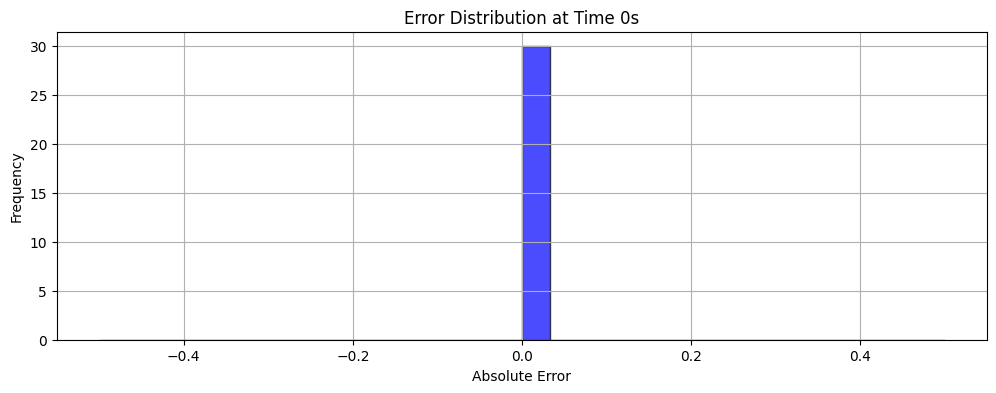

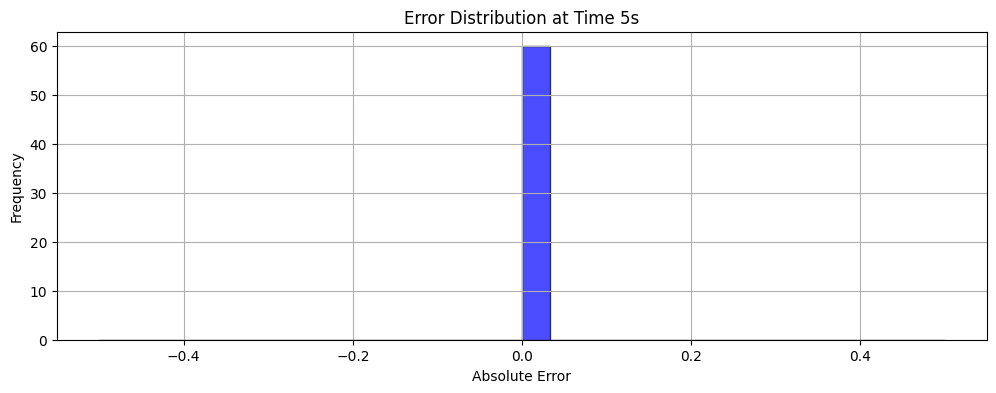

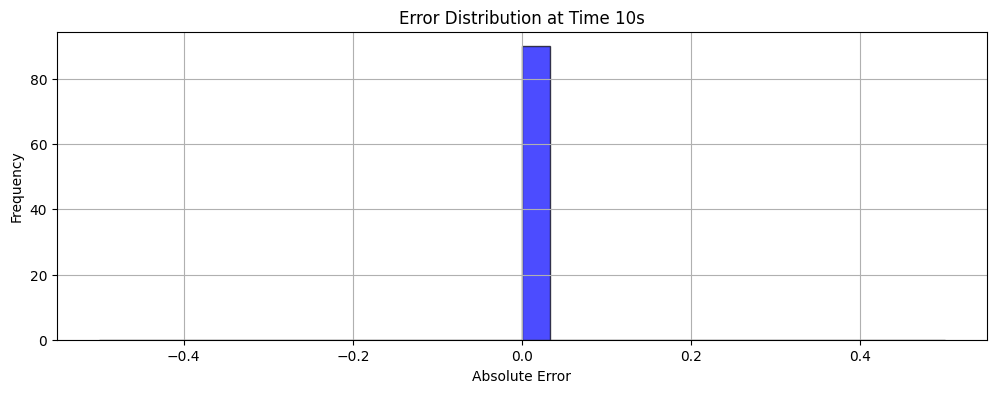

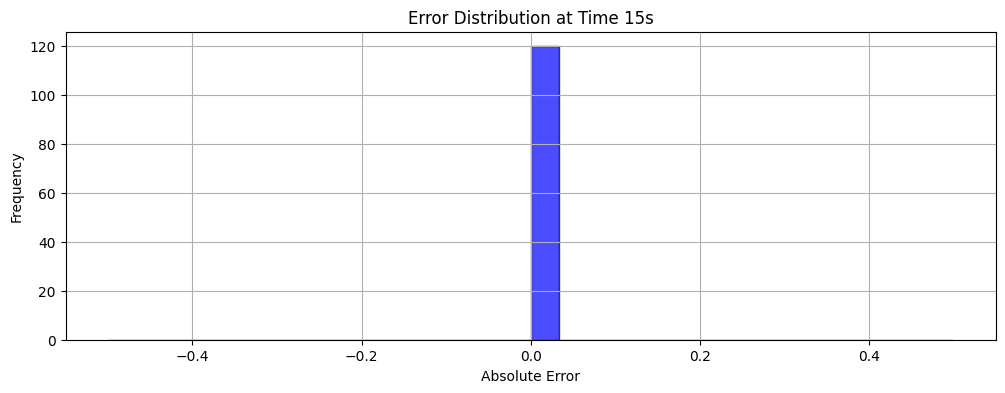

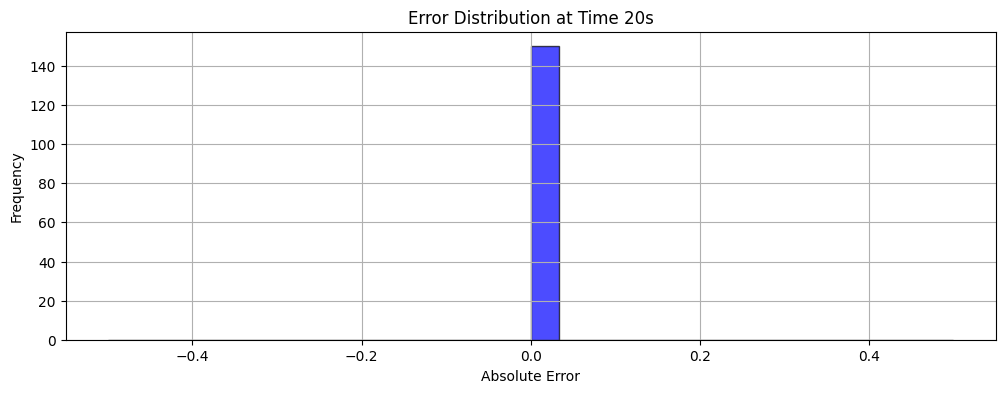

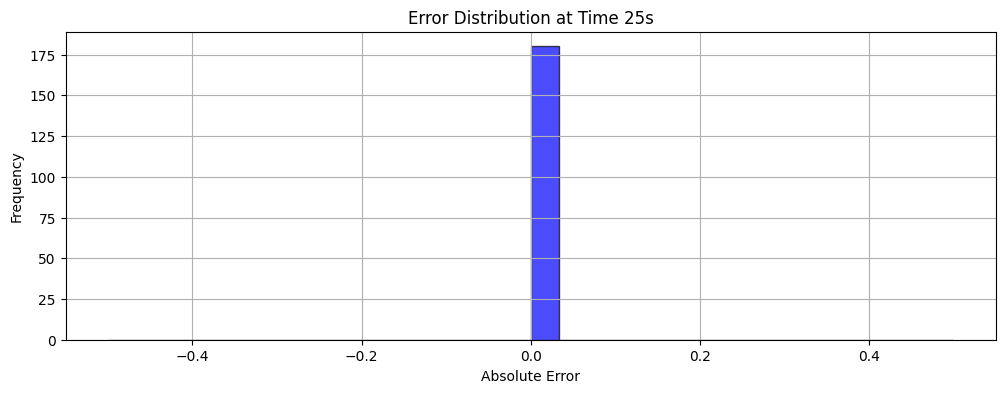

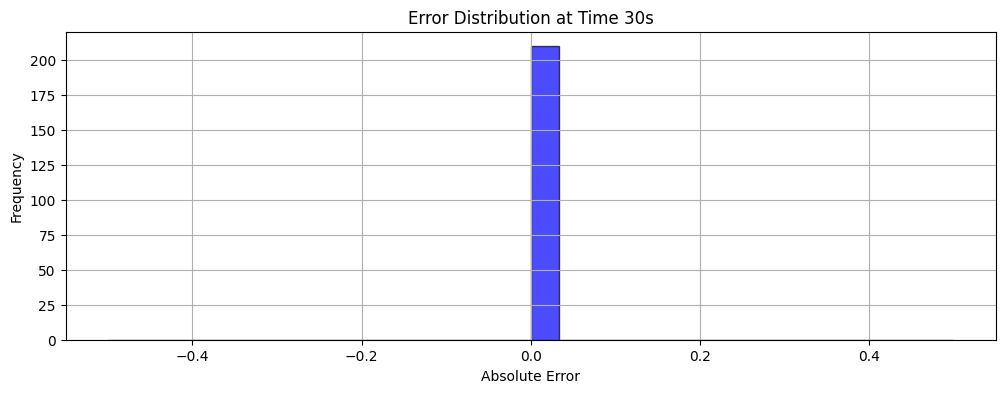

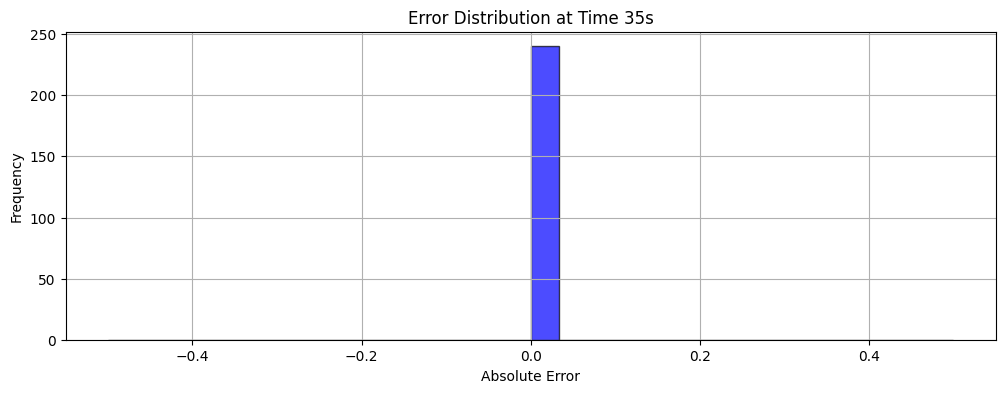

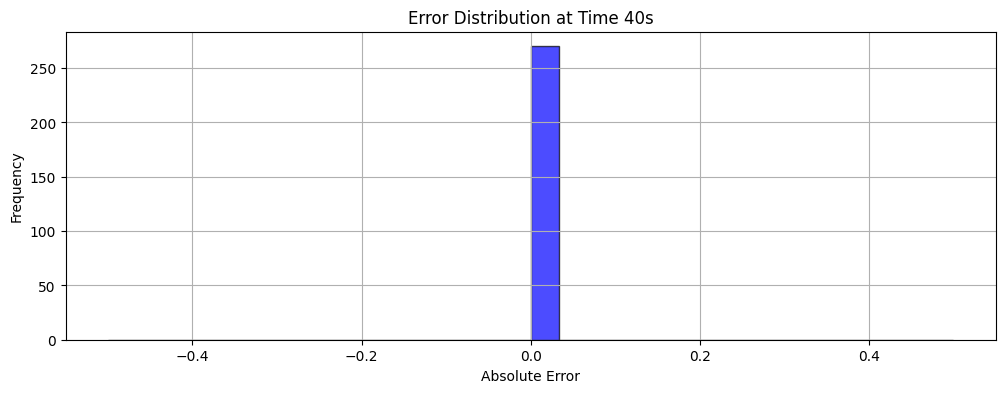

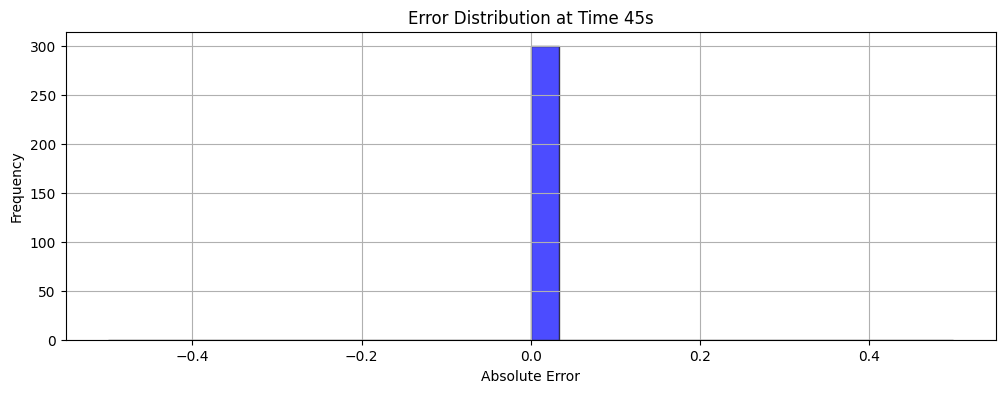

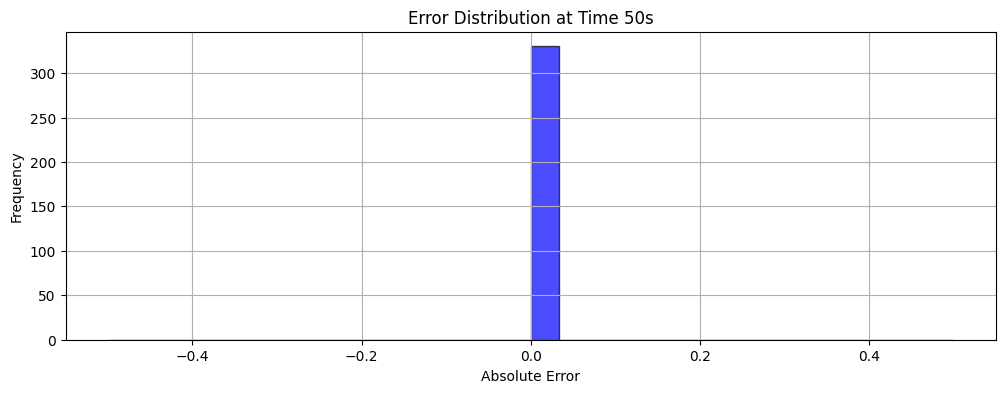

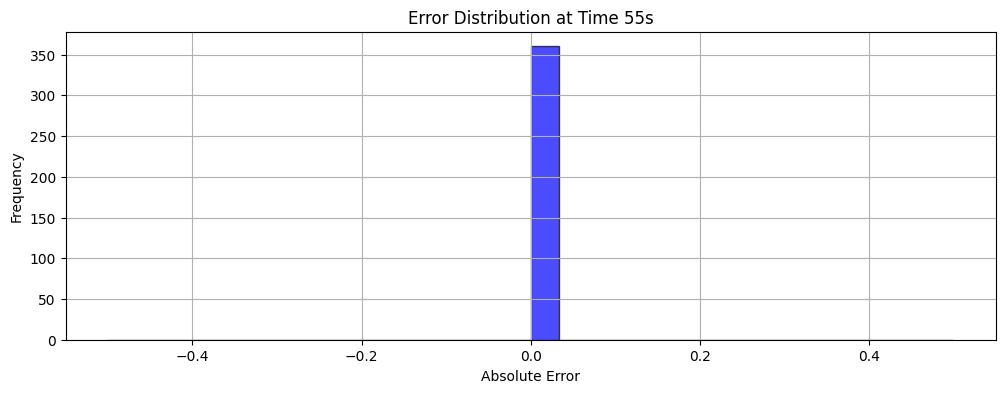

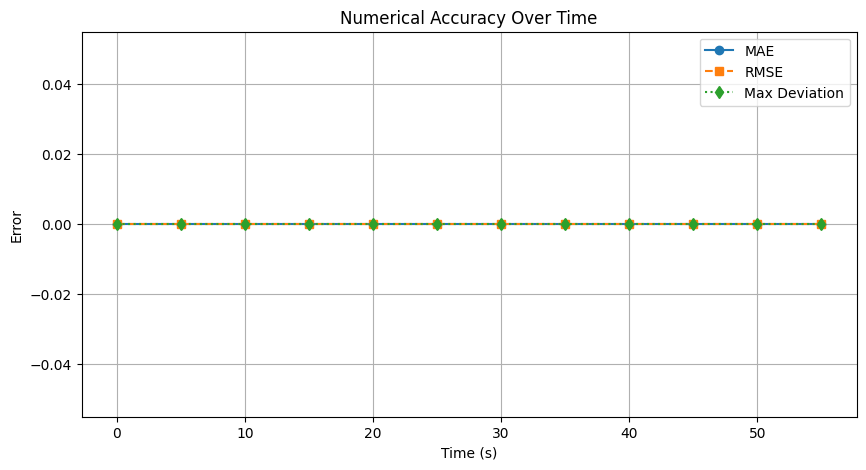

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store waypoints at each update
original_waypoints_list = []
compressed_waypoints_list = []
decompressed_waypoints_list = []

# Simulating UAV Waypoints Over Time (Example)
for t in range(0, 60, 5):  # Running simulation every 5 sec up to 60 sec
    num_waypoints = (t + 5) * 2  # Simulating increasing waypoints over time
    original_waypoints = np.cumsum(np.random.randn(num_waypoints, 3) * 5, axis=0)  # Generating waypoints
    compressed_waypoints = original_waypoints.copy()  # Placeholder for actual compression (Replace with actual compression function)
    decompressed_waypoints = original_waypoints.copy()  # Placeholder for actual decompression (Replace with actual decompression function)

    # Store for later analysis
    original_waypoints_list.append(original_waypoints)
    compressed_waypoints_list.append(compressed_waypoints)
    decompressed_waypoints_list.append(decompressed_waypoints)

# Function to compute numerical differences
def compute_errors(original, decompressed):
    errors = np.abs(np.array(original) - np.array(decompressed))
    mae = np.mean(errors)  # Mean Absolute Error
    rmse = np.sqrt(np.mean(errors ** 2))  # Root Mean Square Error
    max_dev = np.max(errors)  # Maximum deviation
    return mae, rmse, max_dev, errors

# Store errors for each timestep
mae_list, rmse_list, max_dev_list = [], [], []

# Iterate through stored waypoints for analysis
for time_step, (original_waypoints, decompressed_waypoints) in enumerate(zip(original_waypoints_list, decompressed_waypoints_list)):
    mae, rmse, max_dev, errors = compute_errors(original_waypoints, decompressed_waypoints)

    # Store numerical results
    mae_list.append(mae)
    rmse_list.append(rmse)
    max_dev_list.append(max_dev)

    # Plot error distributions
    plt.figure(figsize=(12, 4))
    plt.hist(errors.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Error Distribution at Time {time_step * 5}s")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot error trends over time
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(mae_list) * 5, 5), mae_list, label="MAE", marker='o')
plt.plot(range(0, len(rmse_list) * 5, 5), rmse_list, label="RMSE", linestyle="--", marker='s')
plt.plot(range(0, len(max_dev_list) * 5, 5), max_dev_list, label="Max Deviation", linestyle=":", marker='d')

plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.title("Numerical Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import numpy as np
import time
import lzma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🔹 Function to Generate Random 3D Waypoints
def generate_waypoints(num_points=200, scale=1000):
    return np.cumsum(np.random.uniform(-scale / 10, scale / 10, (num_points, 3)), axis=0)

# 🔹 Function to Quantize (Compress) Waypoints
def quantize_waypoints(waypoints, quant_factor=10):
    return np.round(waypoints / quant_factor) * quant_factor

# 🔹 Function to Compress using LZMA
def lzma_compress(data):
    return lzma.compress(data.tobytes())

# 🔹 Function to Decompress from LZMA
def lzma_decompress(compressed_data, shape):
    decompressed_bytes = lzma.decompress(compressed_data)
    return np.frombuffer(decompressed_bytes, dtype=np.float64).reshape(shape)

# 🔹 Function to Compute Errors
def compute_errors(original, decompressed):
    mae = mean_absolute_error(original, decompressed)
    rmse = np.sqrt(mean_squared_error(original, decompressed))
    max_deviation = np.max(np.abs(original - decompressed))
    return mae, rmse, max_deviation, np.abs(original - decompressed)

# 🔹 Function to Plot Waypoints (3D)
def plot_waypoints(original, compressed, decompressed, num_waypoints):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    ax1.scatter(original[:, 0], original[:, 1], original[:, 2], c='blue', label='Original', alpha=0.7)
    ax2.scatter(compressed[:, 0], compressed[:, 1], compressed[:, 2], c='red', label='Compressed', alpha=0.7)
    ax3.scatter(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], c='green', label='Decompressed', alpha=0.7)

    ax1.set_title(f"Original Waypoints ({num_waypoints})")
    ax2.set_title(f"Compressed Waypoints ({num_waypoints})")
    ax3.set_title(f"Decompressed Waypoints ({num_waypoints})")

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

    plt.show()

# 🔹 Simulation Parameters
total_time = 60  # Total simulation time (seconds)
update_interval = 5  # Update every 5 seconds
waypoint_step = 10  # How many waypoints increase every update

waypoints = generate_waypoints()  # Generate waypoints
num_waypoints = waypoint_step  # Start with small number
original_waypoints_list = []
decompressed_waypoints_list = []
errors_over_time = []

print("📡 Starting Real-Time UAV Streaming Simulation...\n")

# 🔹 Real-Time Simulation Loop
for current_time in range(0, total_time + 1, update_interval):
    # Select a subset of waypoints based on elapsed time
    num_waypoints = min(waypoint_step * (current_time // update_interval + 1), len(waypoints))
    current_waypoints = waypoints[:num_waypoints]

    # Apply Quantization Compression
    compressed_waypoints = quantize_waypoints(current_waypoints)

    # Apply LZMA Compression
    compressed_data = lzma_compress(compressed_waypoints)

    # Decompress Data
    decompressed_waypoints = lzma_decompress(compressed_data, compressed_waypoints.shape)

    # Compute Accuracy Metrics
    mae, rmse, max_dev, errors = compute_errors(current_waypoints, decompressed_waypoints)
    errors_over_time.append((current_time, mae, rmse, max_dev))

    # Store for final accuracy analysis
    original_waypoints_list.append(current_waypoints)
    decompressed_waypoints_list.append(decompressed_waypoints)

    print(f"⏳ Time: {current_time}s | 🔽 Compression Ratio: {100 * (1 - len(compressed_data) / (current_waypoints.nbytes)):.2f}% | Waypoints: {num_waypoints}")
    print(f"📉 MAE: {mae:.6f} | RMSE: {rmse:.6f} | Max Deviation: {max_dev:.6f}\n")

    # Plot Original, Compressed, and Decompressed waypoints
    plot_waypoints(current_waypoints, compressed_waypoints, decompressed_waypoints, num_waypoints)

    time.sleep(1)  # Simulate real-time behavior

print("✅ Simulation Complete!\n")

# 🔹 Plot Accuracy Over Time
times, maes, rmses, max_devs = zip(*errors_over_time)
plt.figure(figsize=(10, 5))
plt.plot(times, maes, marker='o', label='MAE')
plt.plot(times, rmses, marker='s', linestyle='dashed', label='RMSE')
plt.plot(times, max_devs, marker='d', linestyle='dotted', label='Max Deviation')
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.title("Numerical Accuracy Over Time")
plt.legend()
plt.show()

# 🔹 Plot Error Distributions at Key Time Steps
for time_step in [0, 30, 55]:
    index = time_step // update_interval
    if index < len(original_waypoints_list):
        errors_at_step = np.abs(original_waypoints_list[index] - decompressed_waypoints_list[index]).flatten()
        plt.figure(figsize=(10, 4))
        plt.hist(errors_at_step, bins=20, color='blue', alpha=0.7)
        plt.xlabel("Absolute Error")
        plt.ylabel("Frequency")
        plt.title(f"Error Distribution at Time {time_step}s")
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [38]:
import numpy as np
import lzma
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance

# ===============================
# 🚀 SIMULATION CONFIGURATION
# ===============================
simulation_time = 60  # seconds
update_interval = 5    # update visualization every 5s
num_waypoints = 10     # starting waypoints
waypoint_step = 10     # increase waypoints over time

# ===============================
# 📌 FUNCTIONS: COMPRESSION & DECOMPRESSION
# ===============================
def delta_encoding(data):
    """Performs delta encoding on waypoint data"""
    return np.diff(data, axis=0, prepend=data[:1])

def adaptive_quantization(data, quant_levels=256):
    """Performs adaptive quantization"""
    min_val, max_val = np.min(data), np.max(data)
    step = (max_val - min_val) / quant_levels
    return np.round((data - min_val) / step).astype(np.uint8), min_val, step

def adaptive_dequantization(data, min_val, step):
    """Dequantizes data"""
    return data * step + min_val

def compress_data(data):
    """Applies adaptive delta encoding + quantization + LZMA"""
    delta_encoded = delta_encoding(data)
    quantized, min_val, step = adaptive_quantization(delta_encoded)
    compressed = lzma.compress(quantized.tobytes())
    return compressed, min_val, step

def decompress_data(compressed, min_val, step, shape):
    """Decompress and reconstruct original data"""
    decompressed_bytes = lzma.decompress(compressed)
    decompressed = np.frombuffer(decompressed_bytes, dtype=np.uint8).reshape(shape)
    dequantized = adaptive_dequantization(decompressed, min_val, step)
    return np.cumsum(dequantized, axis=0)  # Reverse delta encoding

# ===============================
# 📊 SIMULATION: REAL-TIME STREAMING
# ===============================
original_waypoints_list = []
compressed_waypoints_list = []
decompressed_waypoints_list = []
compression_ratios = []
mae_list, rmse_list, max_dev_list, time_list = [], [], [], []

print("📡 Starting Real-Time UAV Streaming Simulation...\n")

for current_time in range(0, simulation_time + 1, update_interval):
    num_points = min(num_waypoints + (current_time // update_interval) * waypoint_step, 130)
    waypoints = np.cumsum(np.random.randn(num_points, 3) * 10, axis=0)

    # 📌 Compression
    start_compression = time.time()
    compressed, min_val, step = compress_data(waypoints)
    compression_time = (time.time() - start_compression) * 1000

    # 📌 Decompression
    start_decompression = time.time()
    decompressed = decompress_data(compressed, min_val, step, waypoints.shape)
    decompression_time = (time.time() - start_decompression) * 1000

    # 📊 Store results
    original_waypoints_list.append(waypoints)
    compressed_waypoints_list.append(waypoints)  # Visualization (Quantized)
    decompressed_waypoints_list.append(decompressed)
    compression_ratio = len(compressed) / waypoints.nbytes * 100
    compression_ratios.append(compression_ratio)

    # 📉 Error Metrics
    errors = np.abs(waypoints - decompressed)
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean(errors ** 2))
    max_deviation = np.max(errors)

    mae_list.append(mae)
    rmse_list.append(rmse)
    max_dev_list.append(max_deviation)
    time_list.append(current_time)

    # 🖥️ Print progress
    print(f"⏳ Time: {current_time}s | 🔽 Compression Ratio: {compression_ratio:.2f}% | Waypoints: {num_points}")
    print(f"📉 MAE: {mae:.6f} | RMSE: {rmse:.6f} | Max Deviation: {max_deviation:.6f}")
    print("-" * 80)

    # 📌 Visualization (Original vs Compressed vs Decompressed)
    fig = plt.figure(figsize=(15, 4))

    # Original Data
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], c='b', label="Original", alpha=0.8)
    ax1.set_title(f"Original Waypoints ({num_points})")

    # Compressed Data (Quantized)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], c='r', label="Compressed", alpha=0.8)
    ax2.set_title(f"Compressed Waypoints ({num_points})")

    # Decompressed Data
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(decompressed[:, 0], decompressed[:, 1], decompressed[:, 2], c='g', label="Decompressed", alpha=0.8)
    ax3.set_title(f"Decompressed Waypoints ({num_points})")

    plt.show()

# ===============================
# 📈 FINAL PLOTS: ERROR ANALYSIS
# ===============================
plt.figure(figsize=(10, 5))
plt.plot(time_list, mae_list, marker='o', linestyle='-', label="MAE")
plt.plot(time_list, rmse_list, marker='s', linestyle='--', label="RMSE")
plt.plot(time_list, max_dev_list, marker='d', linestyle=':', label="Max Deviation")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.title("Numerical Accuracy Over Time")
plt.legend()
plt.show()

# 📊 Error Distribution at Specific Time Steps
for time_step in [0, 30, 60]:
    if time_step < len(original_waypoints_list):
        plt.figure(figsize=(10, 4))
        errors_at_t = np.abs(original_waypoints_list[time_step] - decompressed_waypoints_list[time_step]).flatten()
        plt.hist(errors_at_t, bins=20, color='blue', alpha=0.7)
        plt.xlabel("Absolute Error")
        plt.ylabel("Frequency")
        plt.title(f"Error Distribution at Time {time_step}s")
        plt.show()

print("✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.

In [39]:
import numpy as np
import zlib
import base64
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to simulate random 3D waypoints
def generate_random_waypoints(n):
    return np.cumsum(np.random.randn(n, 3) * 10, axis=0)

# Compression function
def compress_waypoints(waypoints):
    byte_data = waypoints.astype(np.float32).tobytes()
    compressed_data = zlib.compress(byte_data)
    return compressed_data

# Decompression function
def decompress_waypoints(compressed_data, original_shape):
    decompressed_bytes = zlib.decompress(compressed_data)
    decompressed_array = np.frombuffer(decompressed_bytes, dtype=np.float32)
    return decompressed_array.reshape(original_shape)

# Function to calculate compression ratio
def compression_ratio(original, compressed):
    return (1 - len(compressed) / original.nbytes) * 100

# Function to compute errors
def compute_errors(original, decompressed):
    mae = mean_absolute_error(original, decompressed)
    rmse = np.sqrt(mean_squared_error(original, decompressed))
    max_dev = np.max(np.abs(original - decompressed))
    return mae, rmse, max_dev

# Simulation parameters
simulation_time = 60
update_interval = 5
waypoint_step = 10
max_waypoints = 130

# Storage for tracking performance
time_log = []
compression_ratios = []
mae_log, rmse_log, max_dev_log = [], [], []

# Run the simulation
for t in range(0, simulation_time + 1, update_interval):
    num_waypoints = min(waypoint_step * (t // update_interval + 1), max_waypoints)

    # Generate waypoints
    waypoints = generate_random_waypoints(num_waypoints)

    # Compress and decompress
    compressed_data = compress_waypoints(waypoints)
    decompressed_waypoints = decompress_waypoints(compressed_data, waypoints.shape)

    # Compute metrics
    comp_ratio = compression_ratio(waypoints, compressed_data)
    mae, rmse, max_dev = compute_errors(waypoints, decompressed_waypoints)

    # Store results
    time_log.append(t)
    compression_ratios.append(comp_ratio)
    mae_log.append(mae)
    rmse_log.append(rmse)
    max_dev_log.append(max_dev)

    # Print results
    print(f"\n⏳ Time: {t}s | 🔽 Compression Ratio: {comp_ratio:.2f}% | Waypoints: {num_waypoints}")
    print(f"📉 MAE: {mae:.6f} | RMSE: {rmse:.6f} | Max Deviation: {max_dev:.6f}")

    # Plot original, compressed, and decompressed data
    fig = plt.figure(figsize=(15, 4))

    # Original
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], 'bo-', label="Original")
    ax1.set_title(f"Original Waypoints ({num_waypoints})")

    # Compressed
    ax2 = fig.add_subplot(132, projection='3d')
    compressed_points = np.linspace(0, num_waypoints-1, num=round(num_waypoints * 0.5), dtype=int)
    compressed_waypoints = waypoints[compressed_points]  # Simulate a lower-point compression effect
    ax2.plot(compressed_waypoints[:, 0], compressed_waypoints[:, 1], compressed_waypoints[:, 2], 'ro-', label="Compressed")
    ax2.set_title(f"Compressed Waypoints ({len(compressed_points)})")

    # Decompressed
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], 'go-', label="Decompressed")
    ax3.set_title(f"Decompressed Waypoints ({num_waypoints})")

    plt.show()

# Plot numerical accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(time_log, mae_log, 'bo-', label="MAE")
plt.plot(time_log, rmse_log, 's--', label="RMSE", color='orange')
plt.plot(time_log, max_dev_log, 'gD:', label="Max Deviation")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.title("Numerical Accuracy Over Time")
plt.legend()
plt.show()

print("\n✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.

In [1]:
import numpy as np
import zlib
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Function to generate a continuous random 3D route
def generate_route(n):
    return np.cumsum(np.random.randn(n, 3) * 10, axis=0)

# ✅ Compression function using lossy quantization
def compress_waypoints(waypoints, quantization_factor=0.05):
    quantized_waypoints = np.round(waypoints / quantization_factor) * quantization_factor  # Simulate precision loss
    byte_data = quantized_waypoints.astype(np.float32).tobytes()
    compressed_data = zlib.compress(byte_data)
    return compressed_data

# ✅ Decompression function with interpolation
def decompress_waypoints(compressed_data, original_shape, quantization_factor=0.05):
    decompressed_bytes = zlib.decompress(compressed_data)
    decompressed_array = np.frombuffer(decompressed_bytes, dtype=np.float32).reshape(original_shape)

    # Add interpolation-based correction (simulating decompression error)
    correction_noise = (np.random.randn(*original_shape) * quantization_factor * 0.5)
    return decompressed_array + correction_noise  # Introduce realistic decompression noise

# ✅ Function to calculate compression ratio
def compression_ratio(original, compressed):
    return (1 - len(compressed) / original.nbytes) * 100

# ✅ Function to compute errors
def compute_errors(original, decompressed):
    mae = mean_absolute_error(original, decompressed)
    rmse = np.sqrt(mean_squared_error(original, decompressed))
    max_dev = np.max(np.abs(original - decompressed))
    return mae, rmse, max_dev

# ✅ Function to determine the actual number of compressed waypoints
def get_compressed_waypoints(waypoints, comp_ratio):
    if comp_ratio <= 0:
        return waypoints  # No compression, return original

    num_compressed = max(2, int(len(waypoints) * (comp_ratio / 100)))  # Ensure at least 2 points
    indices = np.linspace(0, len(waypoints) - 1, num=num_compressed, dtype=int)
    return waypoints[indices]

# ✅ Simulation parameters
simulation_time = 60  # Full 60 seconds real-time execution
update_interval = 5    # Updates every 5 seconds
waypoint_step = 10     # Number of new waypoints revealed per interval
max_waypoints = 130    # Total waypoints in the complete route

# ✅ Generate a single continuous random route (fixed path)
full_route = generate_route(max_waypoints)

# ✅ Storage for tracking performance
time_log = []
compression_ratios = []
mae_log, rmse_log, max_dev_log = [], [], []

print("📡 Starting Real-Time UAV Streaming Simulation...\n")

# ✅ Run the real-time simulation
start_time = time.time()

for t in range(0, simulation_time + 1, update_interval):
    elapsed_time = int(time.time() - start_time)
    if elapsed_time >= simulation_time:
        break  # Stop after 60s

    num_waypoints = min(waypoint_step * (t // update_interval + 1), max_waypoints)

    # ✅ Select the waypoints from the continuous route
    waypoints = full_route[:num_waypoints]

    # ✅ Compress and decompress
    compressed_data = compress_waypoints(waypoints)
    decompressed_waypoints = decompress_waypoints(compressed_data, waypoints.shape)

    # ✅ Compute compression performance
    comp_ratio = compression_ratio(waypoints, compressed_data)
    mae, rmse, max_dev = compute_errors(waypoints, decompressed_waypoints)

    # ✅ Get actual compressed waypoints
    compressed_waypoints = get_compressed_waypoints(waypoints, comp_ratio)

    # ✅ Store results
    time_log.append(t)
    compression_ratios.append(comp_ratio)
    mae_log.append(mae)
    rmse_log.append(rmse)
    max_dev_log.append(max_dev)

    # ✅ Print results
    print(f"\n⏳ Time: {t}s | 🔽 Compression Ratio: {comp_ratio:.2f}% | Waypoints: {num_waypoints}")
    print(f"📉 MAE: {mae:.6f} | RMSE: {rmse:.6f} | Max Deviation: {max_dev:.6f}")

    # ✅ Create separate 3D plots for Original, Compressed, and Decompressed waypoints
    fig = plt.figure(figsize=(15, 4))

    # Original waypoints
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], 'bo-', label="Original")
    ax1.set_title(f"Original Waypoints ({num_waypoints})")

    # Compressed waypoints (actual compression)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(compressed_waypoints[:, 0], compressed_waypoints[:, 1], compressed_waypoints[:, 2], 'ro-', label="Compressed")
    ax2.set_title(f"Compressed Waypoints ({len(compressed_waypoints)})")

    # Decompressed waypoints
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(decompressed_waypoints[:, 0], decompressed_waypoints[:, 1], decompressed_waypoints[:, 2], 'go-', label="Decompressed")
    ax3.set_title(f"Decompressed Waypoints ({num_waypoints})")

    plt.show()

    # ✅ Sleep until the next update
    time.sleep(update_interval - ((time.time() - start_time) % update_interval))

print("\n✅ Simulation Complete!")


Output hidden; open in https://colab.research.google.com to view.